In [47]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from gym import spaces

In [48]:
rng = np.random.default_rng(358)

In [49]:
disc_num_actions = 4

In [50]:
# https://www.gymlibrary.ml/environments/box2d/lunar_lander/

In [51]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

def get_actor(num_states, num_actions, upper_bound, continuous=True, layer1=400, layer2=300):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    
    # Different output activation based on discrete or continous version
    if continuous:
        outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    else:
        outputs = layers.Dense(num_actions, activation="softmax", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(num_states, num_actions, layer1=400, layer2=300):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)

    outputs = layers.Dense(num_actions)(out)

    # Make it into a keras model
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [99]:
class Agent:
    def __init__(self, num_states, num_actions, lower_bound, upper_bound, continuous=True,
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005, epsilon=0.2):
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        
        # For methods
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.continuous = continuous

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        # have to change type for gradient calculation
        self.done_buffer = np.zeros((self.buffer_capacity, 1)).astype(np.float32)
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        self.epsilon= epsilon
        
        self.actor_model = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=400, layer2=300)
        self.critic_model = get_critic(num_states, num_actions, layer1=400, layer2=300)

        self.target_actor = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=400, layer2=300)
        self.target_critic = get_critic(num_states, num_actions, layer1=400, layer2=300)
        
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=critic_lr,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=actor_lr,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
        
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple + terminal state
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1
    
    # Move the update and learn function from buffer to Agent to "decrease" scope
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            # Add done_batch to y function for terminal state
            y = reward_batch + done_batch * self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)

        #critic_grad = tf.concat([tf.reshape(gradient, [-1]) for gradient in critic_grad], axis=0)
        
        # clip gradient to avoid big gradients
#         critic_grad = tf.clip_by_global_norm(critic_grad, 1)
        
        #critic_variables = tf.concat([tf.reshape(v, [-1]) for v in self.critic_model.trainable_variables], axis=0)
        
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        # clip actor too
        #actor_grad = tf.concat([tf.reshape(g, [-1]) for g in actor_grad], axis=0)
        #actor_grad = tf.clip_by_value(actor_grad, clip_value_min=-1, clip_value_max=1)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        # Add done_batch for terminal state
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
    def policy(self, state, noise_object=0, use_noise=True, noise_mult=1):
        # Default noise_object to 0 for when it is not needed
        # For doing actions without added noise
        if not use_noise:     
            sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
            legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
        else:
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state))
                noise = noise_object()
                # Adding noise to action
                sampled_actions = sampled_actions.numpy() + noise * noise_mult

                # We make sure action is within bounds
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                
                return [np.squeeze(legal_action)]
            
            else:
                if (rng.random() < self.epsilon):
                    #random move
                    #gets random non-nan index
                    return rng.choice(np.arange(0, disc_num_actions, 1, dtype=int))
                else:
                    sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
                    legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                    return max(0, min(disc_num_actions, int(legal_action)))

In [100]:
def fixed(x, episode):
    return x

In [101]:
def run(total_trials=1, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.3, critic_lr=0.003, render=False,
            actor_lr=0.002, gamma=0.99, tau=0.005, noise_mult=1, save_weights=True, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=20, output=True,
            return_rewards=False, total_time=True, use_guide=False, solved=200,
            continuous=True, environment='LunarLander-v2', seed=1453, start_steps=0,
            gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5,
            epsilon=0.2, epsilon_func=fixed):
    tot_time = time.time()
    
    if environment == 'LunarLander-v2':
        env = gym.make(
            "LunarLander-v2",
            continuous=continuous,
            gravity=gravity,
            enable_wind=enable_wind,
            wind_power=wind_power,
            turbulence_power=turbulence_power
        )
    else:
        env = gym.make(environment)
        
    # Apply the seed
    _ = env.reset(seed=seed)
        
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):
        
        # Stepcount for random start
        step = 0

        # add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=buffer_capacity, 
                batch_size=batch_size, std_dev=std_dev, critic_lr=critic_lr, actor_lr=actor_lr, 
                gamma=gamma, tau=tau)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            
            agent.epsilon = epsilon_func(epsilon, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, noise_object=agent.ou_noise, noise_mult=noise_mult)
                    # To get the right format
                    if continuous:
                        action = action[0]
                else:
                    action = env.action_space.sample()
                
                step += 1
                
                # Recieve state and reward from environment.
                state, reward, done, info = env.step(action)
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Reward modification
                if use_guide:
                    # giving penalty for straying far from flags and having high speed
                    # x max
#                     reward -= int(abs(state[0]) > 0.15) * 2 * abs(state[0])
#                     # y top
#                     reward -= int(state[1] > 1) * state[1] / 2
#                     # horizontal speed
#                     reward -= int(abs(state[2]) > 1) * abs(state[2])
#                     # down speed
#                     reward -= int(state[3] <  -1) * abs(state[3])
#                     # up speed
#                     reward -= int(state[3] > 0.1) * 3 * state[3]
                    reward -= abs(state[2]/2) + abs(state[3]) + (abs(state[0])) + (abs(state[1])/2)

                # Add terminal state for when it has landed. Just look at legs on the ground
                terminal_state = int(state[6] and state[7])
                
                agent.record((prev_state, action, reward, state, terminal_state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                # End this episode if en episode is done
                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            
            true_reward_list[trial].append(true_reward)
            
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)

            # Mean of last x episodes
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            if output:
                print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, true_reward, (time.time() - before), step))
            avg_reward_list[trial].append(avg_reward)
            
            # stop if avg is solved
            if true_avg_reward >= solved:
                break

        # Save weights naming
        now = datetime.datetime.now()
        timestamp = "{}.{}.{}.{}.{}.{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
        save_name = "{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
            environment, total_episodes, 
            buffer_capacity, batch_size, 
            std_dev, critic_lr, actor_lr, 
            gamma, tau, noise_mult, 
            gamma_func.__name__, tau_func.__name__, 
            critic_lr_func.__name__, actor_lr_func.__name__, 
            noise_mult_func.__name__, std_dev_func.__name__, 
            mean_number, use_guide, 
            solved, continuous, 
            start_steps, gravity, 
            enable_wind, wind_power, 
            turbulence_power, timestamp
        )
        if save_weights:
            try:
                agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('actor save fail')
            try:
                agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('critic save fail')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    plt.savefig('Graphs/' + save_name + '.png')
    plt.show()
    
    print('total time:',time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [102]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False,
        environment="LunarLander-v2", continuous=True, gravity=-10.0, enable_wind=False,
        wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power
    )
    
        # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=0, batch_size=0, 
                std_dev=0, critic_lr=0, actor_lr=0, gamma=0, tau=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(state=tf_prev_state, use_noise=False)
            if continuous:
                action = action[0]
            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [103]:
def random(total_episodes=10, render=False, environment="LunarLander-v2", continuous=True,
        gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power,
    )
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [93]:
xax = [x for x in range(-600,250)]

In [94]:
def decreasing_std(x, episode):
    return max(0, min(0.2, 0.2 - (x+500)*(0.2/700)))

In [95]:
def decreasing_alr(x, episode):
    return max(0, min(0.001, 0.001 - (x+500)*(0.001/700)))

In [84]:
def decreasing_clr(x, episode):
    return max(0, min(0.002, 0.002 - (x+500)*(0.002/700)))

In [98]:
def decreasing_eps(x, episode):
    return max(0, min(0.2, 0.2 - (x+500)*(0.2/700)))

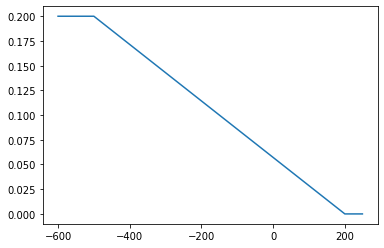

In [85]:
plt.plot(xax,[decreasing_std(x,1) for x in range(-600,250)])

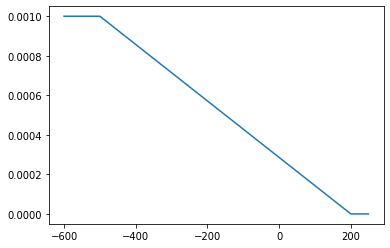

In [86]:
plt.plot(xax,[decreasing_alr(x,1) for x in range(-600,250)])

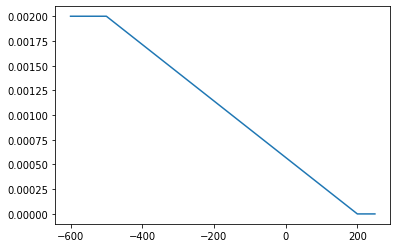

In [63]:
plt.plot(xax,[decreasing_clr(x,1) for x in range(-600,250)])

C:\ProgramData\Miniconda3\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Ep 0 * AvgReward -511.91 * true AvgReward -511.91 * Reward -511.91 * True Reward -511.91 * time 1.67 * step 117
Ep 1 * AvgReward -325.95 * true AvgReward -325.95 * Reward -139.98 * True Reward -139.98 * time 2.73 * step 318
Ep 2 * AvgReward -384.90 * true AvgReward -384.90 * Reward -502.80 * True Reward -502.80 * time 1.86 * step 450
Ep 3 * AvgReward -311.50 * true AvgReward -311.50 * Reward -91.31 * True Reward -91.31 * time 1.84 * step 595
Ep 4 * AvgReward -260.22 * true AvgReward -260.22 * Reward -55.12 * True Reward -55.12 * time 1.03 * step 683
Ep 5 * AvgReward -237.17 * true AvgReward -237.17 * Reward -121.90 * True Reward -121.90 * time 2.18 * step 851
Ep 6 * AvgReward -221.12 * true AvgReward -221.12 * Reward -124.81 * True Reward -124.81 * time 1.18 * step 948
Ep 7 * AvgReward -231.94 * true AvgReward -231.94 * Reward -307.67 * True Reward -307.67 * time 1.03 * step 1039
Ep 8 * AvgReward -214.54 * true AvgReward -214.54 * Reward -75.36 * True Reward -75.36 * time 0.81 * step 1

Ep 73 * AvgReward -222.76 * true AvgReward -222.76 * Reward -154.28 * True Reward -154.28 * time 1.67 * step 9178
Ep 74 * AvgReward -218.08 * true AvgReward -218.08 * Reward -230.52 * True Reward -230.52 * time 1.86 * step 9337
Ep 75 * AvgReward -213.11 * true AvgReward -213.11 * Reward -214.52 * True Reward -214.52 * time 1.05 * step 9428
Ep 76 * AvgReward -230.08 * true AvgReward -230.08 * Reward -494.23 * True Reward -494.23 * time 2.12 * step 9616
Ep 77 * AvgReward -218.37 * true AvgReward -218.37 * Reward -73.90 * True Reward -73.90 * time 0.79 * step 9690
Ep 78 * AvgReward -232.00 * true AvgReward -232.00 * Reward -370.56 * True Reward -370.56 * time 1.10 * step 9783
Ep 79 * AvgReward -230.10 * true AvgReward -230.10 * Reward -84.42 * True Reward -84.42 * time 1.86 * step 9947
Ep 80 * AvgReward -245.83 * true AvgReward -245.83 * Reward -428.12 * True Reward -428.12 * time 4.29 * step 10245
Ep 81 * AvgReward -260.23 * true AvgReward -260.23 * Reward -347.24 * True Reward -347.24 *

Ep 145 * AvgReward -269.20 * true AvgReward -269.20 * Reward -132.50 * True Reward -132.50 * time 2.30 * step 22398
Ep 146 * AvgReward -277.42 * true AvgReward -277.42 * Reward -252.88 * True Reward -252.88 * time 1.20 * step 22480
Ep 147 * AvgReward -288.93 * true AvgReward -288.93 * Reward -265.22 * True Reward -265.22 * time 0.71 * step 22536
Ep 148 * AvgReward -294.24 * true AvgReward -294.24 * Reward -352.63 * True Reward -352.63 * time 0.96 * step 22598
Ep 149 * AvgReward -295.08 * true AvgReward -295.08 * Reward -463.26 * True Reward -463.26 * time 1.37 * step 22690
Ep 150 * AvgReward -285.41 * true AvgReward -285.41 * Reward -344.41 * True Reward -344.41 * time 0.98 * step 22762
Ep 151 * AvgReward -288.87 * true AvgReward -288.87 * Reward -344.79 * True Reward -344.79 * time 0.88 * step 22821
Ep 152 * AvgReward -289.18 * true AvgReward -289.18 * Reward -328.10 * True Reward -328.10 * time 0.97 * step 22891
Ep 153 * AvgReward -280.06 * true AvgReward -280.06 * Reward -316.73 * T

Ep 216 * AvgReward -175.49 * true AvgReward -175.49 * Reward -258.79 * True Reward -258.79 * time 1.51 * step 30871
Ep 217 * AvgReward -167.58 * true AvgReward -167.58 * Reward 4.01 * True Reward 4.01 * time 3.32 * step 31079
Ep 218 * AvgReward -179.21 * true AvgReward -179.21 * Reward -329.02 * True Reward -329.02 * time 1.73 * step 31195
Ep 219 * AvgReward -191.58 * true AvgReward -191.58 * Reward -455.10 * True Reward -455.10 * time 1.53 * step 31295
Ep 220 * AvgReward -210.45 * true AvgReward -210.45 * Reward -390.09 * True Reward -390.09 * time 1.26 * step 31382
Ep 221 * AvgReward -209.07 * true AvgReward -209.07 * Reward -283.53 * True Reward -283.53 * time 1.58 * step 31484
Ep 222 * AvgReward -211.65 * true AvgReward -211.65 * Reward -54.88 * True Reward -54.88 * time 2.93 * step 31671
Ep 223 * AvgReward -220.76 * true AvgReward -220.76 * Reward -422.85 * True Reward -422.85 * time 2.09 * step 31805
Ep 224 * AvgReward -234.73 * true AvgReward -234.73 * Reward -414.94 * True Rewa

Ep 287 * AvgReward -279.11 * true AvgReward -279.11 * Reward -462.12 * True Reward -462.12 * time 2.54 * step 39970
Ep 288 * AvgReward -290.96 * true AvgReward -290.96 * Reward -731.73 * True Reward -731.73 * time 1.59 * step 40075
Ep 289 * AvgReward -314.97 * true AvgReward -314.97 * Reward -651.49 * True Reward -651.49 * time 1.63 * step 40179
Ep 290 * AvgReward -322.78 * true AvgReward -322.78 * Reward -426.29 * True Reward -426.29 * time 1.42 * step 40275
Ep 291 * AvgReward -338.48 * true AvgReward -338.48 * Reward -358.25 * True Reward -358.25 * time 1.62 * step 40376
Ep 292 * AvgReward -343.41 * true AvgReward -343.41 * Reward -424.24 * True Reward -424.24 * time 1.82 * step 40495
Ep 293 * AvgReward -344.15 * true AvgReward -344.15 * Reward -408.04 * True Reward -408.04 * time 2.67 * step 40671
Ep 294 * AvgReward -348.26 * true AvgReward -348.26 * Reward -227.65 * True Reward -227.65 * time 1.84 * step 40799
Ep 295 * AvgReward -356.40 * true AvgReward -356.40 * Reward -302.00 * T

Ep 358 * AvgReward -441.30 * true AvgReward -441.30 * Reward -483.45 * True Reward -483.45 * time 2.10 * step 48440
Ep 359 * AvgReward -441.49 * true AvgReward -441.49 * Reward -250.70 * True Reward -250.70 * time 1.47 * step 48534
Ep 360 * AvgReward -442.60 * true AvgReward -442.60 * Reward -309.46 * True Reward -309.46 * time 1.18 * step 48618
Ep 361 * AvgReward -444.37 * true AvgReward -444.37 * Reward -268.11 * True Reward -268.11 * time 1.50 * step 48716
Ep 362 * AvgReward -434.90 * true AvgReward -434.90 * Reward -300.09 * True Reward -300.09 * time 1.72 * step 48831
Ep 363 * AvgReward -414.65 * true AvgReward -414.65 * Reward -179.31 * True Reward -179.31 * time 1.88 * step 48954
Ep 364 * AvgReward -391.85 * true AvgReward -391.85 * Reward -240.17 * True Reward -240.17 * time 2.50 * step 49114
Ep 365 * AvgReward -390.33 * true AvgReward -390.33 * Reward -274.71 * True Reward -274.71 * time 2.86 * step 49294
Ep 366 * AvgReward -388.69 * true AvgReward -388.69 * Reward -396.53 * T

Ep 429 * AvgReward -435.15 * true AvgReward -435.15 * Reward -330.16 * True Reward -330.16 * time 1.62 * step 56923
Ep 430 * AvgReward -443.35 * true AvgReward -443.35 * Reward -238.57 * True Reward -238.57 * time 1.55 * step 57027
Ep 431 * AvgReward -464.62 * true AvgReward -464.62 * Reward -558.40 * True Reward -558.40 * time 1.46 * step 57126
Ep 432 * AvgReward -459.11 * true AvgReward -459.11 * Reward -465.57 * True Reward -465.57 * time 1.66 * step 57237
Ep 433 * AvgReward -463.34 * true AvgReward -463.34 * Reward -215.91 * True Reward -215.91 * time 2.18 * step 57378
Ep 434 * AvgReward -449.50 * true AvgReward -449.50 * Reward -274.75 * True Reward -274.75 * time 1.47 * step 57479
Ep 435 * AvgReward -439.36 * true AvgReward -439.36 * Reward -182.88 * True Reward -182.88 * time 1.53 * step 57579
Ep 436 * AvgReward -429.29 * true AvgReward -429.29 * Reward -187.46 * True Reward -187.46 * time 1.42 * step 57675
Ep 437 * AvgReward -423.68 * true AvgReward -423.68 * Reward -248.48 * T

Ep 500 * AvgReward -449.55 * true AvgReward -449.55 * Reward -545.31 * True Reward -545.31 * time 1.53 * step 65664
Ep 501 * AvgReward -434.40 * true AvgReward -434.40 * Reward -253.00 * True Reward -253.00 * time 1.42 * step 65760
Ep 502 * AvgReward -433.86 * true AvgReward -433.86 * Reward -280.16 * True Reward -280.16 * time 3.87 * step 66005
Ep 503 * AvgReward -440.26 * true AvgReward -440.26 * Reward -326.15 * True Reward -326.15 * time 1.33 * step 66098
Ep 504 * AvgReward -420.74 * true AvgReward -420.74 * Reward -44.97 * True Reward -44.97 * time 2.11 * step 66236
Ep 505 * AvgReward -398.02 * true AvgReward -398.02 * Reward -71.63 * True Reward -71.63 * time 2.09 * step 66374
Ep 506 * AvgReward -387.00 * true AvgReward -387.00 * Reward -182.95 * True Reward -182.95 * time 2.53 * step 66543
Ep 507 * AvgReward -385.57 * true AvgReward -385.57 * Reward -156.74 * True Reward -156.74 * time 2.58 * step 66713
Ep 508 * AvgReward -383.06 * true AvgReward -383.06 * Reward -289.31 * True 

Ep 571 * AvgReward -375.53 * true AvgReward -375.53 * Reward -503.32 * True Reward -503.32 * time 3.20 * step 77081
Ep 572 * AvgReward -357.96 * true AvgReward -357.96 * Reward -90.96 * True Reward -90.96 * time 2.32 * step 77232
Ep 573 * AvgReward -373.13 * true AvgReward -373.13 * Reward -599.32 * True Reward -599.32 * time 3.68 * step 77468
Ep 574 * AvgReward -382.06 * true AvgReward -382.06 * Reward -408.86 * True Reward -408.86 * time 3.16 * step 77671
Ep 575 * AvgReward -400.69 * true AvgReward -400.69 * Reward -605.76 * True Reward -605.76 * time 1.50 * step 77777
Ep 576 * AvgReward -414.07 * true AvgReward -414.07 * Reward -611.34 * True Reward -611.34 * time 1.56 * step 77878
Ep 577 * AvgReward -409.08 * true AvgReward -409.08 * Reward -238.12 * True Reward -238.12 * time 1.69 * step 77990
Ep 578 * AvgReward -401.54 * true AvgReward -401.54 * Reward -140.67 * True Reward -140.67 * time 1.90 * step 78112
Ep 579 * AvgReward -407.93 * true AvgReward -407.93 * Reward -358.30 * Tru

Ep 642 * AvgReward -253.39 * true AvgReward -253.39 * Reward -310.00 * True Reward -310.00 * time 1.38 * step 88344
Ep 643 * AvgReward -256.58 * true AvgReward -256.58 * Reward -233.54 * True Reward -233.54 * time 2.28 * step 88528
Ep 644 * AvgReward -263.77 * true AvgReward -263.77 * Reward -381.37 * True Reward -381.37 * time 2.10 * step 88676
Ep 645 * AvgReward -244.92 * true AvgReward -244.92 * Reward -86.53 * True Reward -86.53 * time 3.35 * step 88897
Ep 646 * AvgReward -260.39 * true AvgReward -260.39 * Reward -322.44 * True Reward -322.44 * time 3.11 * step 89102
Ep 647 * AvgReward -271.35 * true AvgReward -271.35 * Reward -490.12 * True Reward -490.12 * time 11.80 * step 89799
Ep 648 * AvgReward -273.85 * true AvgReward -273.85 * Reward -348.03 * True Reward -348.03 * time 1.54 * step 89909
Ep 649 * AvgReward -300.52 * true AvgReward -300.52 * Reward -682.98 * True Reward -682.98 * time 1.52 * step 90016
Ep 650 * AvgReward -315.86 * true AvgReward -315.86 * Reward -423.30 * Tr

Ep 713 * AvgReward -421.91 * true AvgReward -421.91 * Reward -257.36 * True Reward -257.36 * time 1.09 * step 98714
Ep 714 * AvgReward -412.48 * true AvgReward -412.48 * Reward -349.07 * True Reward -349.07 * time 0.96 * step 98782
Ep 715 * AvgReward -419.28 * true AvgReward -419.28 * Reward -443.85 * True Reward -443.85 * time 1.69 * step 98894
Ep 716 * AvgReward -395.99 * true AvgReward -395.99 * Reward -328.35 * True Reward -328.35 * time 2.34 * step 99046
Ep 717 * AvgReward -386.41 * true AvgReward -386.41 * Reward -156.31 * True Reward -156.31 * time 2.62 * step 99216
Ep 718 * AvgReward -362.64 * true AvgReward -362.64 * Reward -230.31 * True Reward -230.31 * time 2.15 * step 99354
Ep 719 * AvgReward -308.37 * true AvgReward -308.37 * Reward -387.85 * True Reward -387.85 * time 3.93 * step 99596
Ep 720 * AvgReward -293.61 * true AvgReward -293.61 * Reward -324.73 * True Reward -324.73 * time 3.94 * step 99839
Ep 721 * AvgReward -286.94 * true AvgReward -286.94 * Reward -368.77 * T

Ep 784 * AvgReward -317.02 * true AvgReward -317.02 * Reward -383.27 * True Reward -383.27 * time 1.74 * step 109449
Ep 785 * AvgReward -314.70 * true AvgReward -314.70 * Reward -243.11 * True Reward -243.11 * time 1.93 * step 109576
Ep 786 * AvgReward -309.16 * true AvgReward -309.16 * Reward -248.88 * True Reward -248.88 * time 3.01 * step 109766
Ep 787 * AvgReward -322.87 * true AvgReward -322.87 * Reward -482.14 * True Reward -482.14 * time 1.93 * step 109892
Ep 788 * AvgReward -310.86 * true AvgReward -310.86 * Reward -196.17 * True Reward -196.17 * time 2.96 * step 110077
Ep 789 * AvgReward -302.52 * true AvgReward -302.52 * Reward -131.57 * True Reward -131.57 * time 2.26 * step 110222
Ep 790 * AvgReward -312.34 * true AvgReward -312.34 * Reward -459.35 * True Reward -459.35 * time 2.85 * step 110404
Ep 791 * AvgReward -307.93 * true AvgReward -307.93 * Reward -213.83 * True Reward -213.83 * time 1.93 * step 110534
Ep 792 * AvgReward -316.87 * true AvgReward -316.87 * Reward -46

Ep 855 * AvgReward -408.07 * true AvgReward -408.07 * Reward -433.65 * True Reward -433.65 * time 1.47 * step 119314
Ep 856 * AvgReward -409.22 * true AvgReward -409.22 * Reward -306.31 * True Reward -306.31 * time 2.46 * step 119476
Ep 857 * AvgReward -449.95 * true AvgReward -449.95 * Reward -1162.42 * True Reward -1162.42 * time 3.58 * step 119704
Ep 858 * AvgReward -438.81 * true AvgReward -438.81 * Reward -48.70 * True Reward -48.70 * time 2.01 * step 119835
Ep 859 * AvgReward -444.79 * true AvgReward -444.79 * Reward -348.58 * True Reward -348.58 * time 2.30 * step 119984
Ep 860 * AvgReward -417.96 * true AvgReward -417.96 * Reward -197.20 * True Reward -197.20 * time 1.72 * step 120095
Ep 861 * AvgReward -413.97 * true AvgReward -413.97 * Reward -222.46 * True Reward -222.46 * time 1.99 * step 120226
Ep 862 * AvgReward -396.09 * true AvgReward -396.09 * Reward -195.71 * True Reward -195.71 * time 2.49 * step 120386
Ep 863 * AvgReward -375.24 * true AvgReward -375.24 * Reward -18

Ep 926 * AvgReward -288.24 * true AvgReward -288.24 * Reward -290.08 * True Reward -290.08 * time 2.03 * step 129673
Ep 927 * AvgReward -287.20 * true AvgReward -287.20 * Reward -113.36 * True Reward -113.36 * time 1.74 * step 129786
Ep 928 * AvgReward -287.78 * true AvgReward -287.78 * Reward -202.90 * True Reward -202.90 * time 1.86 * step 129903
Ep 929 * AvgReward -295.76 * true AvgReward -295.76 * Reward -404.41 * True Reward -404.41 * time 2.29 * step 130051
Ep 930 * AvgReward -283.87 * true AvgReward -283.87 * Reward -123.85 * True Reward -123.85 * time 1.78 * step 130166
Ep 931 * AvgReward -286.51 * true AvgReward -286.51 * Reward -345.64 * True Reward -345.64 * time 1.44 * step 130265
Ep 932 * AvgReward -272.45 * true AvgReward -272.45 * Reward -139.84 * True Reward -139.84 * time 2.83 * step 130449
Ep 933 * AvgReward -261.52 * true AvgReward -261.52 * Reward -160.78 * True Reward -160.78 * time 1.86 * step 130569
Ep 934 * AvgReward -264.36 * true AvgReward -264.36 * Reward -25

Ep 996 * AvgReward -517.46 * true AvgReward -517.46 * Reward -602.44 * True Reward -602.44 * time 1.49 * step 139502
Ep 997 * AvgReward -528.28 * true AvgReward -528.28 * Reward -510.15 * True Reward -510.15 * time 1.55 * step 139599
Ep 998 * AvgReward -542.51 * true AvgReward -542.51 * Reward -611.03 * True Reward -611.03 * time 1.46 * step 139691
Ep 999 * AvgReward -545.19 * true AvgReward -545.19 * Reward -235.80 * True Reward -235.80 * time 2.11 * step 139823
Ep 0 * AvgReward -266.19 * true AvgReward -266.19 * Reward -266.19 * True Reward -266.19 * time 1.88 * step 115
Ep 1 * AvgReward -315.17 * true AvgReward -315.17 * Reward -364.16 * True Reward -364.16 * time 1.00 * step 198
Ep 2 * AvgReward -227.47 * true AvgReward -227.47 * Reward -52.07 * True Reward -52.07 * time 1.14 * step 291
Ep 3 * AvgReward -234.45 * true AvgReward -234.45 * Reward -255.39 * True Reward -255.39 * time 1.27 * step 404
Ep 4 * AvgReward -260.33 * true AvgReward -260.33 * Reward -363.84 * True Reward -363.

Ep 69 * AvgReward -220.20 * true AvgReward -220.20 * Reward -126.57 * True Reward -126.57 * time 0.80 * step 8410
Ep 70 * AvgReward -206.64 * true AvgReward -206.64 * Reward -95.48 * True Reward -95.48 * time 0.89 * step 8484
Ep 71 * AvgReward -205.59 * true AvgReward -205.59 * Reward -114.99 * True Reward -114.99 * time 1.67 * step 8647
Ep 72 * AvgReward -203.19 * true AvgReward -203.19 * Reward -239.41 * True Reward -239.41 * time 0.93 * step 8741
Ep 73 * AvgReward -203.04 * true AvgReward -203.04 * Reward -317.15 * True Reward -317.15 * time 0.90 * step 8830
Ep 74 * AvgReward -213.60 * true AvgReward -213.60 * Reward -240.66 * True Reward -240.66 * time 0.73 * step 8905
Ep 75 * AvgReward -207.97 * true AvgReward -207.97 * Reward -326.93 * True Reward -326.93 * time 1.45 * step 9030
Ep 76 * AvgReward -210.99 * true AvgReward -210.99 * Reward -204.67 * True Reward -204.67 * time 1.22 * step 9129
Ep 77 * AvgReward -224.63 * true AvgReward -224.63 * Reward -388.50 * True Reward -388.50 

Ep 141 * AvgReward -218.49 * true AvgReward -218.49 * Reward -404.64 * True Reward -404.64 * time 14.83 * step 22404
Ep 142 * AvgReward -245.28 * true AvgReward -245.28 * Reward -544.05 * True Reward -544.05 * time 9.01 * step 22906
Ep 143 * AvgReward -238.86 * true AvgReward -238.86 * Reward -5.20 * True Reward -5.20 * time 3.10 * step 23098
Ep 144 * AvgReward -226.50 * true AvgReward -226.50 * Reward 15.08 * True Reward 15.08 * time 1.61 * step 23202
Ep 145 * AvgReward -237.02 * true AvgReward -237.02 * Reward -215.57 * True Reward -215.57 * time 2.12 * step 23340
Ep 146 * AvgReward -255.52 * true AvgReward -255.52 * Reward -551.21 * True Reward -551.21 * time 6.79 * step 23755
Ep 147 * AvgReward -271.87 * true AvgReward -271.87 * Reward -644.10 * True Reward -644.10 * time 12.70 * step 24421
Ep 148 * AvgReward -269.63 * true AvgReward -269.63 * Reward -390.64 * True Reward -390.64 * time 5.65 * step 24757
Ep 149 * AvgReward -275.81 * true AvgReward -275.81 * Reward -365.01 * True Re

Ep 212 * AvgReward -256.08 * true AvgReward -256.08 * Reward -58.30 * True Reward -58.30 * time 1.21 * step 36831
Ep 213 * AvgReward -253.20 * true AvgReward -253.20 * Reward -185.96 * True Reward -185.96 * time 1.90 * step 36951
Ep 214 * AvgReward -234.05 * true AvgReward -234.05 * Reward -105.87 * True Reward -105.87 * time 1.40 * step 37042
Ep 215 * AvgReward -242.42 * true AvgReward -242.42 * Reward -270.21 * True Reward -270.21 * time 2.25 * step 37185
Ep 216 * AvgReward -240.73 * true AvgReward -240.73 * Reward -308.81 * True Reward -308.81 * time 4.27 * step 37462
Ep 217 * AvgReward -250.52 * true AvgReward -250.52 * Reward -343.87 * True Reward -343.87 * time 2.05 * step 37600
Ep 218 * AvgReward -252.47 * true AvgReward -252.47 * Reward -369.67 * True Reward -369.67 * time 1.24 * step 37690
Ep 219 * AvgReward -253.64 * true AvgReward -253.64 * Reward -295.46 * True Reward -295.46 * time 1.16 * step 37774
Ep 220 * AvgReward -250.94 * true AvgReward -250.94 * Reward -307.13 * Tru

Ep 283 * AvgReward -426.02 * true AvgReward -426.02 * Reward -312.27 * True Reward -312.27 * time 2.05 * step 47387
Ep 284 * AvgReward -441.53 * true AvgReward -441.53 * Reward -645.86 * True Reward -645.86 * time 2.88 * step 47569
Ep 285 * AvgReward -423.18 * true AvgReward -423.18 * Reward -67.97 * True Reward -67.97 * time 2.14 * step 47715
Ep 286 * AvgReward -424.09 * true AvgReward -424.09 * Reward -255.27 * True Reward -255.27 * time 1.86 * step 47838
Ep 287 * AvgReward -410.43 * true AvgReward -410.43 * Reward -337.48 * True Reward -337.48 * time 1.92 * step 47957
Ep 288 * AvgReward -416.15 * true AvgReward -416.15 * Reward -468.38 * True Reward -468.38 * time 1.97 * step 48087
Ep 289 * AvgReward -391.47 * true AvgReward -391.47 * Reward -71.33 * True Reward -71.33 * time 2.36 * step 48238
Ep 290 * AvgReward -386.06 * true AvgReward -386.06 * Reward -294.16 * True Reward -294.16 * time 2.17 * step 48376
Ep 291 * AvgReward -389.48 * true AvgReward -389.48 * Reward -337.47 * True 

Ep 354 * AvgReward -402.06 * true AvgReward -402.06 * Reward -282.26 * True Reward -282.26 * time 1.63 * step 56457
Ep 355 * AvgReward -393.64 * true AvgReward -393.64 * Reward -312.66 * True Reward -312.66 * time 1.33 * step 56555
Ep 356 * AvgReward -390.23 * true AvgReward -390.23 * Reward -426.27 * True Reward -426.27 * time 2.24 * step 56702
Ep 357 * AvgReward -388.78 * true AvgReward -388.78 * Reward -378.14 * True Reward -378.14 * time 1.29 * step 56786
Ep 358 * AvgReward -384.45 * true AvgReward -384.45 * Reward -339.75 * True Reward -339.75 * time 2.01 * step 56917
Ep 359 * AvgReward -380.74 * true AvgReward -380.74 * Reward -295.21 * True Reward -295.21 * time 2.44 * step 57073
Ep 360 * AvgReward -373.99 * true AvgReward -373.99 * Reward -213.29 * True Reward -213.29 * time 1.35 * step 57164
Ep 361 * AvgReward -364.89 * true AvgReward -364.89 * Reward -346.48 * True Reward -346.48 * time 1.22 * step 57239
Ep 362 * AvgReward -350.48 * true AvgReward -350.48 * Reward -476.27 * T

Ep 425 * AvgReward -354.78 * true AvgReward -354.78 * Reward -386.00 * True Reward -386.00 * time 2.63 * step 66174
Ep 426 * AvgReward -363.76 * true AvgReward -363.76 * Reward -474.79 * True Reward -474.79 * time 2.12 * step 66315
Ep 427 * AvgReward -387.53 * true AvgReward -387.53 * Reward -999.17 * True Reward -999.17 * time 3.67 * step 66554
Ep 428 * AvgReward -389.63 * true AvgReward -389.63 * Reward -427.79 * True Reward -427.79 * time 1.37 * step 66649
Ep 429 * AvgReward -377.10 * true AvgReward -377.10 * Reward -233.06 * True Reward -233.06 * time 2.47 * step 66816
Ep 430 * AvgReward -386.16 * true AvgReward -386.16 * Reward -561.39 * True Reward -561.39 * time 1.66 * step 66924
Ep 431 * AvgReward -400.50 * true AvgReward -400.50 * Reward -335.48 * True Reward -335.48 * time 2.25 * step 67077
Ep 432 * AvgReward -422.54 * true AvgReward -422.54 * Reward -640.35 * True Reward -640.35 * time 1.49 * step 67177
Ep 433 * AvgReward -433.05 * true AvgReward -433.05 * Reward -435.03 * T

Ep 496 * AvgReward -547.92 * true AvgReward -547.92 * Reward -560.54 * True Reward -560.54 * time 2.90 * step 76707
Ep 497 * AvgReward -565.83 * true AvgReward -565.83 * Reward -655.87 * True Reward -655.87 * time 2.37 * step 76861
Ep 498 * AvgReward -583.54 * true AvgReward -583.54 * Reward -754.12 * True Reward -754.12 * time 2.49 * step 77033
Ep 499 * AvgReward -566.17 * true AvgReward -566.17 * Reward -302.93 * True Reward -302.93 * time 2.64 * step 77208
Ep 500 * AvgReward -559.10 * true AvgReward -559.10 * Reward -804.11 * True Reward -804.11 * time 3.13 * step 77404
Ep 501 * AvgReward -579.71 * true AvgReward -579.71 * Reward -734.38 * True Reward -734.38 * time 2.95 * step 77591
Ep 502 * AvgReward -583.50 * true AvgReward -583.50 * Reward -653.91 * True Reward -653.91 * time 3.51 * step 77811
Ep 503 * AvgReward -554.40 * true AvgReward -554.40 * Reward -409.77 * True Reward -409.77 * time 2.76 * step 77987
Ep 504 * AvgReward -573.40 * true AvgReward -573.40 * Reward -907.27 * T

Ep 567 * AvgReward -451.13 * true AvgReward -451.13 * Reward -419.83 * True Reward -419.83 * time 1.48 * step 87104
Ep 568 * AvgReward -453.01 * true AvgReward -453.01 * Reward -384.21 * True Reward -384.21 * time 1.15 * step 87183
Ep 569 * AvgReward -432.36 * true AvgReward -432.36 * Reward -154.77 * True Reward -154.77 * time 0.97 * step 87251
Ep 570 * AvgReward -414.53 * true AvgReward -414.53 * Reward -311.96 * True Reward -311.96 * time 0.99 * step 87315
Ep 571 * AvgReward -402.15 * true AvgReward -402.15 * Reward -448.13 * True Reward -448.13 * time 1.17 * step 87397
Ep 572 * AvgReward -390.45 * true AvgReward -390.45 * Reward -426.63 * True Reward -426.63 * time 0.84 * step 87453
Ep 573 * AvgReward -388.52 * true AvgReward -388.52 * Reward -406.10 * True Reward -406.10 * time 1.07 * step 87522
Ep 574 * AvgReward -381.93 * true AvgReward -381.93 * Reward -291.12 * True Reward -291.12 * time 0.71 * step 87570
Ep 575 * AvgReward -379.47 * true AvgReward -379.47 * Reward -473.50 * T

Ep 638 * AvgReward -359.15 * true AvgReward -359.15 * Reward -454.90 * True Reward -454.90 * time 2.96 * step 94755
Ep 639 * AvgReward -368.56 * true AvgReward -368.56 * Reward -388.57 * True Reward -388.57 * time 2.87 * step 94942
Ep 640 * AvgReward -372.40 * true AvgReward -372.40 * Reward -424.96 * True Reward -424.96 * time 2.94 * step 95120
Ep 641 * AvgReward -374.83 * true AvgReward -374.83 * Reward -370.25 * True Reward -370.25 * time 2.78 * step 95303
Ep 642 * AvgReward -383.40 * true AvgReward -383.40 * Reward -524.07 * True Reward -524.07 * time 2.60 * step 95462
Ep 643 * AvgReward -388.51 * true AvgReward -388.51 * Reward -400.47 * True Reward -400.47 * time 1.51 * step 95554
Ep 644 * AvgReward -399.35 * true AvgReward -399.35 * Reward -507.59 * True Reward -507.59 * time 1.29 * step 95641
Ep 645 * AvgReward -416.32 * true AvgReward -416.32 * Reward -436.41 * True Reward -436.41 * time 1.37 * step 95731
Ep 646 * AvgReward -417.87 * true AvgReward -417.87 * Reward -373.17 * T

Ep 709 * AvgReward -353.14 * true AvgReward -353.14 * Reward -674.11 * True Reward -674.11 * time 2.92 * step 104862
Ep 710 * AvgReward -362.01 * true AvgReward -362.01 * Reward -316.22 * True Reward -316.22 * time 1.51 * step 104960
Ep 711 * AvgReward -369.44 * true AvgReward -369.44 * Reward -475.32 * True Reward -475.32 * time 2.15 * step 105092
Ep 712 * AvgReward -373.68 * true AvgReward -373.68 * Reward -352.65 * True Reward -352.65 * time 1.08 * step 105163
Ep 713 * AvgReward -381.50 * true AvgReward -381.50 * Reward -403.15 * True Reward -403.15 * time 1.19 * step 105244
Ep 714 * AvgReward -358.38 * true AvgReward -358.38 * Reward -43.63 * True Reward -43.63 * time 0.83 * step 105303
Ep 715 * AvgReward -358.74 * true AvgReward -358.74 * Reward -262.65 * True Reward -262.65 * time 0.94 * step 105361
Ep 716 * AvgReward -353.26 * true AvgReward -353.26 * Reward -168.65 * True Reward -168.65 * time 1.03 * step 105434
Ep 717 * AvgReward -358.70 * true AvgReward -358.70 * Reward -402.

Ep 780 * AvgReward -410.29 * true AvgReward -410.29 * Reward -303.47 * True Reward -303.47 * time 1.11 * step 117448
Ep 781 * AvgReward -407.64 * true AvgReward -407.64 * Reward -256.53 * True Reward -256.53 * time 2.78 * step 117619
Ep 782 * AvgReward -416.63 * true AvgReward -416.63 * Reward -348.62 * True Reward -348.62 * time 4.46 * step 117888
Ep 783 * AvgReward -401.63 * true AvgReward -401.63 * Reward -228.76 * True Reward -228.76 * time 3.97 * step 118119
Ep 784 * AvgReward -445.71 * true AvgReward -445.71 * Reward -1191.42 * True Reward -1191.42 * time 5.54 * step 118443
Ep 785 * AvgReward -458.92 * true AvgReward -458.92 * Reward -675.45 * True Reward -675.45 * time 1.70 * step 118550
Ep 786 * AvgReward -457.44 * true AvgReward -457.44 * Reward -329.35 * True Reward -329.35 * time 2.40 * step 118703
Ep 787 * AvgReward -447.41 * true AvgReward -447.41 * Reward -356.77 * True Reward -356.77 * time 3.93 * step 118963
Ep 788 * AvgReward -430.33 * true AvgReward -430.33 * Reward -

Ep 851 * AvgReward -343.47 * true AvgReward -343.47 * Reward -470.23 * True Reward -470.23 * time 4.09 * step 129899
Ep 852 * AvgReward -346.48 * true AvgReward -346.48 * Reward -329.37 * True Reward -329.37 * time 6.51 * step 130286
Ep 853 * AvgReward -356.31 * true AvgReward -356.31 * Reward -377.11 * True Reward -377.11 * time 5.20 * step 130595
Ep 854 * AvgReward -367.50 * true AvgReward -367.50 * Reward -469.50 * True Reward -469.50 * time 5.08 * step 130920
Ep 855 * AvgReward -361.55 * true AvgReward -361.55 * Reward -386.24 * True Reward -386.24 * time 3.90 * step 131168
Ep 856 * AvgReward -364.52 * true AvgReward -364.52 * Reward -524.72 * True Reward -524.72 * time 3.82 * step 131422
Ep 857 * AvgReward -365.81 * true AvgReward -365.81 * Reward -291.74 * True Reward -291.74 * time 4.57 * step 131694
Ep 858 * AvgReward -353.00 * true AvgReward -353.00 * Reward -224.00 * True Reward -224.00 * time 2.94 * step 131885
Ep 859 * AvgReward -346.40 * true AvgReward -346.40 * Reward -24

Ep 922 * AvgReward -312.21 * true AvgReward -312.21 * Reward -474.71 * True Reward -474.71 * time 7.40 * step 145505
Ep 923 * AvgReward -302.01 * true AvgReward -302.01 * Reward -274.44 * True Reward -274.44 * time 5.75 * step 145840
Ep 924 * AvgReward -282.76 * true AvgReward -282.76 * Reward -192.56 * True Reward -192.56 * time 2.46 * step 145998
Ep 925 * AvgReward -293.26 * true AvgReward -293.26 * Reward -577.04 * True Reward -577.04 * time 9.35 * step 146550
Ep 926 * AvgReward -292.94 * true AvgReward -292.94 * Reward -297.72 * True Reward -297.72 * time 1.65 * step 146657
Ep 927 * AvgReward -300.50 * true AvgReward -300.50 * Reward -368.88 * True Reward -368.88 * time 1.81 * step 146774
Ep 928 * AvgReward -301.03 * true AvgReward -301.03 * Reward -236.00 * True Reward -236.00 * time 3.24 * step 146974
Ep 929 * AvgReward -320.04 * true AvgReward -320.04 * Reward -607.88 * True Reward -607.88 * time 3.74 * step 147189
Ep 930 * AvgReward -325.98 * true AvgReward -325.98 * Reward -38

Ep 993 * AvgReward -259.29 * true AvgReward -259.29 * Reward -420.96 * True Reward -420.96 * time 2.92 * step 157146
Ep 994 * AvgReward -277.20 * true AvgReward -277.20 * Reward -533.01 * True Reward -533.01 * time 3.45 * step 157358
Ep 995 * AvgReward -281.67 * true AvgReward -281.67 * Reward -442.17 * True Reward -442.17 * time 3.38 * step 157568
Ep 996 * AvgReward -292.07 * true AvgReward -292.07 * Reward -376.15 * True Reward -376.15 * time 4.52 * step 157836
Ep 997 * AvgReward -286.09 * true AvgReward -286.09 * Reward -195.77 * True Reward -195.77 * time 3.42 * step 158043
Ep 998 * AvgReward -290.11 * true AvgReward -290.11 * Reward -241.83 * True Reward -241.83 * time 5.13 * step 158344
Ep 999 * AvgReward -288.01 * true AvgReward -288.01 * Reward -183.59 * True Reward -183.59 * time 2.31 * step 158494


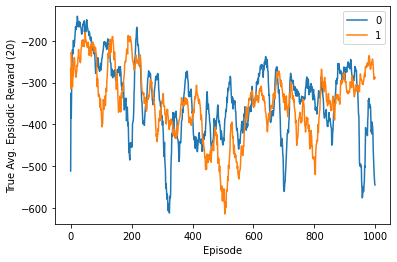

total time: 4586.228585243225 s


In [15]:
run(total_trials=1, total_episodes=1000, buffer_capacity=300000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=10000, continuous=True)

In [16]:
#test(render=True, actor_weights='Weights/actor-trial1_LunarLander-v2_2500_50000_64_0.3_0.003_0.002_0.99_0.005_1_fixed_fixed_fixed_fixed_fixed_fixed_20_False_200_True_10000_-10.0_False_15.0_1.5_2022.8.1.8.55.0.h5', continuous=True, total_episodes=30)

Ep 0 * AvgReward -140.11 * true AvgReward -140.11 * Reward -140.11 * True Reward -140.11 * time 3.08 * step 161
Ep 1 * AvgReward -269.53 * true AvgReward -269.53 * Reward -398.96 * True Reward -398.96 * time 1.10 * step 248
Ep 2 * AvgReward -263.66 * true AvgReward -263.66 * Reward -251.92 * True Reward -251.92 * time 1.04 * step 330
Ep 3 * AvgReward -217.19 * true AvgReward -217.19 * Reward -77.77 * True Reward -77.77 * time 1.07 * step 412
Ep 4 * AvgReward -187.26 * true AvgReward -187.26 * Reward -67.54 * True Reward -67.54 * time 1.00 * step 494
Ep 5 * AvgReward -231.84 * true AvgReward -231.84 * Reward -454.75 * True Reward -454.75 * time 1.24 * step 586
Ep 6 * AvgReward -204.61 * true AvgReward -204.61 * Reward -41.19 * True Reward -41.19 * time 1.36 * step 691
Ep 7 * AvgReward -196.32 * true AvgReward -196.32 * Reward -138.30 * True Reward -138.30 * time 1.48 * step 816
Ep 8 * AvgReward -182.18 * true AvgReward -182.18 * Reward -69.08 * True Reward -69.08 * time 1.17 * step 915


Ep 73 * AvgReward -261.32 * true AvgReward -261.32 * Reward -266.23 * True Reward -266.23 * time 1.37 * step 8370
Ep 74 * AvgReward -245.01 * true AvgReward -245.01 * Reward -156.50 * True Reward -156.50 * time 2.00 * step 8520
Ep 75 * AvgReward -234.05 * true AvgReward -234.05 * Reward -139.41 * True Reward -139.41 * time 0.95 * step 8602
Ep 76 * AvgReward -245.32 * true AvgReward -245.32 * Reward -296.59 * True Reward -296.59 * time 1.46 * step 8715
Ep 77 * AvgReward -238.44 * true AvgReward -238.44 * Reward -211.83 * True Reward -211.83 * time 0.93 * step 8782
Ep 78 * AvgReward -235.12 * true AvgReward -235.12 * Reward -185.45 * True Reward -185.45 * time 1.43 * step 8886
Ep 79 * AvgReward -225.27 * true AvgReward -225.27 * Reward -144.90 * True Reward -144.90 * time 1.48 * step 9001
Ep 80 * AvgReward -233.17 * true AvgReward -233.17 * Reward -391.40 * True Reward -391.40 * time 1.07 * step 9084
Ep 81 * AvgReward -231.85 * true AvgReward -231.85 * Reward -143.98 * True Reward -143.9

Ep 145 * AvgReward -297.73 * true AvgReward -297.73 * Reward -480.84 * True Reward -480.84 * time 1.51 * step 22857
Ep 146 * AvgReward -285.61 * true AvgReward -285.61 * Reward -551.53 * True Reward -551.53 * time 1.00 * step 22923
Ep 147 * AvgReward -302.04 * true AvgReward -302.04 * Reward -402.60 * True Reward -402.60 * time 1.06 * step 22996
Ep 148 * AvgReward -311.58 * true AvgReward -311.58 * Reward -326.51 * True Reward -326.51 * time 1.03 * step 23058
Ep 149 * AvgReward -314.21 * true AvgReward -314.21 * Reward -268.86 * True Reward -268.86 * time 1.59 * step 23163
Ep 150 * AvgReward -316.44 * true AvgReward -316.44 * Reward -311.98 * True Reward -311.98 * time 1.31 * step 23249
Ep 151 * AvgReward -320.92 * true AvgReward -320.92 * Reward -268.32 * True Reward -268.32 * time 1.69 * step 23357
Ep 152 * AvgReward -314.19 * true AvgReward -314.19 * Reward -150.74 * True Reward -150.74 * time 1.72 * step 23468
Ep 153 * AvgReward -351.37 * true AvgReward -351.37 * Reward -909.37 * T

Ep 216 * AvgReward -512.95 * true AvgReward -512.95 * Reward -463.87 * True Reward -463.87 * time 2.81 * step 36094
Ep 217 * AvgReward -512.17 * true AvgReward -512.17 * Reward -427.92 * True Reward -427.92 * time 2.12 * step 36231
Ep 218 * AvgReward -501.58 * true AvgReward -501.58 * Reward -379.83 * True Reward -379.83 * time 2.09 * step 36377
Ep 219 * AvgReward -489.87 * true AvgReward -489.87 * Reward -388.85 * True Reward -388.85 * time 1.64 * step 36489
Ep 220 * AvgReward -481.01 * true AvgReward -481.01 * Reward -283.82 * True Reward -283.82 * time 1.75 * step 36600
Ep 221 * AvgReward -485.97 * true AvgReward -485.97 * Reward -385.50 * True Reward -385.50 * time 1.54 * step 36703
Ep 222 * AvgReward -500.51 * true AvgReward -500.51 * Reward -466.94 * True Reward -466.94 * time 1.72 * step 36820
Ep 223 * AvgReward -497.61 * true AvgReward -497.61 * Reward -414.75 * True Reward -414.75 * time 3.16 * step 37022
Ep 224 * AvgReward -444.50 * true AvgReward -444.50 * Reward -381.32 * T

Ep 287 * AvgReward -478.69 * true AvgReward -478.69 * Reward -439.34 * True Reward -439.34 * time 1.69 * step 47547
Ep 288 * AvgReward -523.72 * true AvgReward -523.72 * Reward -1160.68 * True Reward -1160.68 * time 2.81 * step 47718
Ep 289 * AvgReward -532.59 * true AvgReward -532.59 * Reward -334.72 * True Reward -334.72 * time 2.33 * step 47873
Ep 290 * AvgReward -562.26 * true AvgReward -562.26 * Reward -1239.20 * True Reward -1239.20 * time 3.49 * step 48096
Ep 291 * AvgReward -592.89 * true AvgReward -592.89 * Reward -1078.47 * True Reward -1078.47 * time 2.09 * step 48224
Ep 292 * AvgReward -570.30 * true AvgReward -570.30 * Reward -812.98 * True Reward -812.98 * time 2.65 * step 48381
Ep 293 * AvgReward -579.08 * true AvgReward -579.08 * Reward -1015.68 * True Reward -1015.68 * time 1.58 * step 48479
Ep 294 * AvgReward -570.95 * true AvgReward -570.95 * Reward -108.98 * True Reward -108.98 * time 1.52 * step 48581
Ep 295 * AvgReward -592.79 * true AvgReward -592.79 * Reward -78

Ep 358 * AvgReward -725.56 * true AvgReward -725.56 * Reward -405.63 * True Reward -405.63 * time 3.69 * step 57134
Ep 359 * AvgReward -752.76 * true AvgReward -752.76 * Reward -1135.88 * True Reward -1135.88 * time 3.70 * step 57359
Ep 360 * AvgReward -757.99 * true AvgReward -757.99 * Reward -383.58 * True Reward -383.58 * time 3.03 * step 57540
Ep 361 * AvgReward -743.25 * true AvgReward -743.25 * Reward -279.57 * True Reward -279.57 * time 4.57 * step 57802
Ep 362 * AvgReward -693.40 * true AvgReward -693.40 * Reward -404.91 * True Reward -404.91 * time 3.65 * step 58012
Ep 363 * AvgReward -678.78 * true AvgReward -678.78 * Reward -268.10 * True Reward -268.10 * time 2.56 * step 58165
Ep 364 * AvgReward -711.23 * true AvgReward -711.23 * Reward -1152.71 * True Reward -1152.71 * time 3.28 * step 58377
Ep 365 * AvgReward -703.41 * true AvgReward -703.41 * Reward -983.22 * True Reward -983.22 * time 3.57 * step 58590
Ep 366 * AvgReward -657.84 * true AvgReward -657.84 * Reward -270.46

Ep 429 * AvgReward -395.01 * true AvgReward -395.01 * Reward -597.41 * True Reward -597.41 * time 1.61 * step 69431
Ep 430 * AvgReward -417.82 * true AvgReward -417.82 * Reward -667.43 * True Reward -667.43 * time 4.97 * step 69719
Ep 431 * AvgReward -438.34 * true AvgReward -438.34 * Reward -458.08 * True Reward -458.08 * time 3.46 * step 69923
Ep 432 * AvgReward -451.50 * true AvgReward -451.50 * Reward -541.18 * True Reward -541.18 * time 2.36 * step 70074
Ep 433 * AvgReward -433.65 * true AvgReward -433.65 * Reward -337.74 * True Reward -337.74 * time 2.11 * step 70201
Ep 434 * AvgReward -434.03 * true AvgReward -434.03 * Reward -220.99 * True Reward -220.99 * time 2.21 * step 70336
Ep 435 * AvgReward -461.66 * true AvgReward -461.66 * Reward -796.13 * True Reward -796.13 * time 3.12 * step 70519
Ep 436 * AvgReward -480.43 * true AvgReward -480.43 * Reward -577.16 * True Reward -577.16 * time 2.38 * step 70675
Ep 437 * AvgReward -466.78 * true AvgReward -466.78 * Reward -388.27 * T

Ep 500 * AvgReward -342.48 * true AvgReward -342.48 * Reward -331.80 * True Reward -331.80 * time 3.17 * step 79440
Ep 501 * AvgReward -352.60 * true AvgReward -352.60 * Reward -472.82 * True Reward -472.82 * time 2.43 * step 79589
Ep 502 * AvgReward -354.70 * true AvgReward -354.70 * Reward -245.31 * True Reward -245.31 * time 3.86 * step 79822
Ep 503 * AvgReward -350.38 * true AvgReward -350.38 * Reward -283.22 * True Reward -283.22 * time 2.17 * step 79962
Ep 504 * AvgReward -345.00 * true AvgReward -345.00 * Reward -439.78 * True Reward -439.78 * time 2.46 * step 80116
Ep 505 * AvgReward -357.43 * true AvgReward -357.43 * Reward -395.17 * True Reward -395.17 * time 3.17 * step 80320
Ep 506 * AvgReward -355.88 * true AvgReward -355.88 * Reward -341.49 * True Reward -341.49 * time 4.78 * step 80598
Ep 507 * AvgReward -361.24 * true AvgReward -361.24 * Reward -238.91 * True Reward -238.91 * time 2.76 * step 80763
Ep 508 * AvgReward -352.85 * true AvgReward -352.85 * Reward -174.79 * T

Ep 571 * AvgReward -351.83 * true AvgReward -351.83 * Reward -393.97 * True Reward -393.97 * time 4.14 * step 90985
Ep 572 * AvgReward -341.73 * true AvgReward -341.73 * Reward -75.71 * True Reward -75.71 * time 2.79 * step 91162
Ep 573 * AvgReward -330.22 * true AvgReward -330.22 * Reward -254.93 * True Reward -254.93 * time 4.08 * step 91390
Ep 574 * AvgReward -335.03 * true AvgReward -335.03 * Reward -349.41 * True Reward -349.41 * time 3.62 * step 91601
Ep 575 * AvgReward -324.34 * true AvgReward -324.34 * Reward -46.38 * True Reward -46.38 * time 3.93 * step 91829
Ep 576 * AvgReward -325.33 * true AvgReward -325.33 * Reward -374.73 * True Reward -374.73 * time 2.99 * step 92000
Ep 577 * AvgReward -329.55 * true AvgReward -329.55 * Reward -219.57 * True Reward -219.57 * time 5.68 * step 92322
Ep 578 * AvgReward -309.23 * true AvgReward -309.23 * Reward -281.25 * True Reward -281.25 * time 2.87 * step 92499
Ep 579 * AvgReward -310.11 * true AvgReward -310.11 * Reward -223.19 * True 

Ep 642 * AvgReward -460.30 * true AvgReward -460.30 * Reward -249.46 * True Reward -249.46 * time 1.67 * step 101503
Ep 643 * AvgReward -474.61 * true AvgReward -474.61 * Reward -669.89 * True Reward -669.89 * time 1.67 * step 101605
Ep 644 * AvgReward -466.56 * true AvgReward -466.56 * Reward -444.14 * True Reward -444.14 * time 3.22 * step 101791
Ep 645 * AvgReward -478.70 * true AvgReward -478.70 * Reward -535.12 * True Reward -535.12 * time 1.97 * step 101909
Ep 646 * AvgReward -503.77 * true AvgReward -503.77 * Reward -887.92 * True Reward -887.92 * time 3.85 * step 102129
Ep 647 * AvgReward -513.14 * true AvgReward -513.14 * Reward -479.00 * True Reward -479.00 * time 2.69 * step 102291
Ep 648 * AvgReward -503.32 * true AvgReward -503.32 * Reward -248.04 * True Reward -248.04 * time 1.62 * step 102382
Ep 649 * AvgReward -514.15 * true AvgReward -514.15 * Reward -307.54 * True Reward -307.54 * time 3.02 * step 102551
Ep 650 * AvgReward -502.50 * true AvgReward -502.50 * Reward -29

Ep 713 * AvgReward -384.58 * true AvgReward -384.58 * Reward -169.97 * True Reward -169.97 * time 3.79 * step 112518
Ep 714 * AvgReward -376.93 * true AvgReward -376.93 * Reward -338.64 * True Reward -338.64 * time 2.66 * step 112673
Ep 715 * AvgReward -384.42 * true AvgReward -384.42 * Reward -559.74 * True Reward -559.74 * time 3.70 * step 112890
Ep 716 * AvgReward -399.82 * true AvgReward -399.82 * Reward -478.62 * True Reward -478.62 * time 2.90 * step 113074
Ep 717 * AvgReward -392.07 * true AvgReward -392.07 * Reward -351.84 * True Reward -351.84 * time 2.92 * step 113250
Ep 718 * AvgReward -409.71 * true AvgReward -409.71 * Reward -755.84 * True Reward -755.84 * time 3.30 * step 113459
Ep 719 * AvgReward -408.07 * true AvgReward -408.07 * Reward -434.60 * True Reward -434.60 * time 2.83 * step 113627
Ep 720 * AvgReward -407.95 * true AvgReward -407.95 * Reward -278.90 * True Reward -278.90 * time 1.49 * step 113717
Ep 721 * AvgReward -398.43 * true AvgReward -398.43 * Reward -57

Ep 784 * AvgReward -274.62 * true AvgReward -274.62 * Reward -135.34 * True Reward -135.34 * time 0.92 * step 120910
Ep 785 * AvgReward -271.64 * true AvgReward -271.64 * Reward -286.81 * True Reward -286.81 * time 1.58 * step 121000
Ep 786 * AvgReward -274.79 * true AvgReward -274.79 * Reward -321.54 * True Reward -321.54 * time 1.66 * step 121102
Ep 787 * AvgReward -272.43 * true AvgReward -272.43 * Reward -185.13 * True Reward -185.13 * time 7.21 * step 121473
Ep 788 * AvgReward -268.55 * true AvgReward -268.55 * Reward -235.59 * True Reward -235.59 * time 1.70 * step 121574
Ep 789 * AvgReward -278.57 * true AvgReward -278.57 * Reward -439.87 * True Reward -439.87 * time 2.95 * step 121745
Ep 790 * AvgReward -291.67 * true AvgReward -291.67 * Reward -418.24 * True Reward -418.24 * time 3.64 * step 121956
Ep 791 * AvgReward -288.56 * true AvgReward -288.56 * Reward -262.20 * True Reward -262.20 * time 3.80 * step 122168
Ep 792 * AvgReward -292.91 * true AvgReward -292.91 * Reward -62

Ep 855 * AvgReward -386.51 * true AvgReward -386.51 * Reward -290.60 * True Reward -290.60 * time 4.74 * step 132783
Ep 856 * AvgReward -397.49 * true AvgReward -397.49 * Reward -547.91 * True Reward -547.91 * time 3.62 * step 132998
Ep 857 * AvgReward -378.54 * true AvgReward -378.54 * Reward -344.16 * True Reward -344.16 * time 4.93 * step 133279
Ep 858 * AvgReward -358.85 * true AvgReward -358.85 * Reward -114.82 * True Reward -114.82 * time 3.83 * step 133495
Ep 859 * AvgReward -343.17 * true AvgReward -343.17 * Reward -508.21 * True Reward -508.21 * time 4.46 * step 133747
Ep 860 * AvgReward -348.53 * true AvgReward -348.53 * Reward -358.01 * True Reward -358.01 * time 3.07 * step 133936
Ep 861 * AvgReward -368.35 * true AvgReward -368.35 * Reward -599.39 * True Reward -599.39 * time 4.59 * step 134191
Ep 862 * AvgReward -361.64 * true AvgReward -361.64 * Reward -355.42 * True Reward -355.42 * time 3.16 * step 134377
Ep 863 * AvgReward -371.09 * true AvgReward -371.09 * Reward -27

Ep 926 * AvgReward -347.55 * true AvgReward -347.55 * Reward -287.66 * True Reward -287.66 * time 3.84 * step 146542
Ep 927 * AvgReward -336.73 * true AvgReward -336.73 * Reward -325.08 * True Reward -325.08 * time 2.15 * step 146669
Ep 928 * AvgReward -329.14 * true AvgReward -329.14 * Reward -139.79 * True Reward -139.79 * time 2.94 * step 146829
Ep 929 * AvgReward -338.76 * true AvgReward -338.76 * Reward -466.03 * True Reward -466.03 * time 4.46 * step 147074
Ep 930 * AvgReward -334.72 * true AvgReward -334.72 * Reward -301.24 * True Reward -301.24 * time 2.95 * step 147240
Ep 931 * AvgReward -356.04 * true AvgReward -356.04 * Reward -424.86 * True Reward -424.86 * time 3.58 * step 147438
Ep 932 * AvgReward -359.34 * true AvgReward -359.34 * Reward -503.31 * True Reward -503.31 * time 4.03 * step 147669
Ep 933 * AvgReward -355.65 * true AvgReward -355.65 * Reward -454.20 * True Reward -454.20 * time 4.06 * step 147900
Ep 934 * AvgReward -363.79 * true AvgReward -363.79 * Reward -48

Ep 997 * AvgReward -326.26 * true AvgReward -326.26 * Reward -478.33 * True Reward -478.33 * time 2.11 * step 157817
Ep 998 * AvgReward -315.84 * true AvgReward -315.84 * Reward -165.50 * True Reward -165.50 * time 1.69 * step 157910
Ep 999 * AvgReward -311.38 * true AvgReward -311.38 * Reward -365.55 * True Reward -365.55 * time 3.36 * step 158095
Ep 1000 * AvgReward -299.86 * true AvgReward -299.86 * Reward -273.26 * True Reward -273.26 * time 3.33 * step 158282
Ep 1001 * AvgReward -293.15 * true AvgReward -293.15 * Reward -328.52 * True Reward -328.52 * time 3.93 * step 158497
Ep 1002 * AvgReward -274.65 * true AvgReward -274.65 * Reward -94.85 * True Reward -94.85 * time 3.69 * step 158707
Ep 1003 * AvgReward -278.04 * true AvgReward -278.04 * Reward -262.44 * True Reward -262.44 * time 2.33 * step 158839
Ep 1004 * AvgReward -284.41 * true AvgReward -284.41 * Reward -309.01 * True Reward -309.01 * time 2.81 * step 158997
Ep 1005 * AvgReward -288.86 * true AvgReward -288.86 * Reward

Ep 1067 * AvgReward -542.00 * true AvgReward -542.00 * Reward -31.09 * True Reward -31.09 * time 2.53 * step 167219
Ep 1068 * AvgReward -527.91 * true AvgReward -527.91 * Reward -424.98 * True Reward -424.98 * time 3.27 * step 167403
Ep 1069 * AvgReward -510.65 * true AvgReward -510.65 * Reward -204.35 * True Reward -204.35 * time 3.05 * step 167581
Ep 1070 * AvgReward -498.13 * true AvgReward -498.13 * Reward -394.76 * True Reward -394.76 * time 2.21 * step 167707
Ep 1071 * AvgReward -476.95 * true AvgReward -476.95 * Reward -337.44 * True Reward -337.44 * time 3.80 * step 167912
Ep 1072 * AvgReward -461.99 * true AvgReward -461.99 * Reward -441.20 * True Reward -441.20 * time 2.86 * step 168074
Ep 1073 * AvgReward -438.81 * true AvgReward -438.81 * Reward -243.90 * True Reward -243.90 * time 3.28 * step 168259
Ep 1074 * AvgReward -422.84 * true AvgReward -422.84 * Reward -361.63 * True Reward -361.63 * time 3.36 * step 168431
Ep 1075 * AvgReward -428.92 * true AvgReward -428.92 * Rew

Ep 1137 * AvgReward -282.40 * true AvgReward -282.40 * Reward -470.56 * True Reward -470.56 * time 3.30 * step 177506
Ep 1138 * AvgReward -299.25 * true AvgReward -299.25 * Reward -440.55 * True Reward -440.55 * time 2.12 * step 177613
Ep 1139 * AvgReward -304.13 * true AvgReward -304.13 * Reward -432.49 * True Reward -432.49 * time 5.79 * step 177923
Ep 1140 * AvgReward -307.43 * true AvgReward -307.43 * Reward -355.04 * True Reward -355.04 * time 1.51 * step 178006
Ep 1141 * AvgReward -310.88 * true AvgReward -310.88 * Reward -457.56 * True Reward -457.56 * time 3.60 * step 178192
Ep 1142 * AvgReward -325.37 * true AvgReward -325.37 * Reward -581.39 * True Reward -581.39 * time 3.44 * step 178378
Ep 1143 * AvgReward -328.87 * true AvgReward -328.87 * Reward -274.10 * True Reward -274.10 * time 2.07 * step 178495
Ep 1144 * AvgReward -325.60 * true AvgReward -325.60 * Reward -309.47 * True Reward -309.47 * time 3.81 * step 178705
Ep 1145 * AvgReward -321.49 * true AvgReward -321.49 * R

Ep 1207 * AvgReward -336.78 * true AvgReward -336.78 * Reward -448.68 * True Reward -448.68 * time 2.61 * step 187999
Ep 1208 * AvgReward -326.26 * true AvgReward -326.26 * Reward -261.13 * True Reward -261.13 * time 3.55 * step 188183
Ep 1209 * AvgReward -334.34 * true AvgReward -334.34 * Reward -498.17 * True Reward -498.17 * time 4.48 * step 188410
Ep 1210 * AvgReward -332.13 * true AvgReward -332.13 * Reward -238.67 * True Reward -238.67 * time 2.09 * step 188518
Ep 1211 * AvgReward -332.56 * true AvgReward -332.56 * Reward -211.77 * True Reward -211.77 * time 3.22 * step 188691
Ep 1212 * AvgReward -329.45 * true AvgReward -329.45 * Reward -173.76 * True Reward -173.76 * time 1.86 * step 188800
Ep 1213 * AvgReward -318.23 * true AvgReward -318.23 * Reward -209.84 * True Reward -209.84 * time 1.47 * step 188889
Ep 1214 * AvgReward -319.30 * true AvgReward -319.30 * Reward -341.91 * True Reward -341.91 * time 1.49 * step 188965
Ep 1215 * AvgReward -322.35 * true AvgReward -322.35 * R

Ep 1277 * AvgReward -329.66 * true AvgReward -329.66 * Reward -625.98 * True Reward -625.98 * time 1.76 * step 199182
Ep 1278 * AvgReward -331.95 * true AvgReward -331.95 * Reward -396.25 * True Reward -396.25 * time 2.71 * step 199333
Ep 1279 * AvgReward -341.05 * true AvgReward -341.05 * Reward -397.42 * True Reward -397.42 * time 1.59 * step 199429
Ep 1280 * AvgReward -348.97 * true AvgReward -348.97 * Reward -405.76 * True Reward -405.76 * time 2.03 * step 199540
Ep 1281 * AvgReward -339.83 * true AvgReward -339.83 * Reward -263.93 * True Reward -263.93 * time 4.42 * step 199772
Ep 1282 * AvgReward -346.26 * true AvgReward -346.26 * Reward -521.31 * True Reward -521.31 * time 2.48 * step 199910
Ep 1283 * AvgReward -347.55 * true AvgReward -347.55 * Reward -234.63 * True Reward -234.63 * time 3.17 * step 200078
Ep 1284 * AvgReward -332.20 * true AvgReward -332.20 * Reward -128.91 * True Reward -128.91 * time 1.59 * step 200172
Ep 1285 * AvgReward -328.87 * true AvgReward -328.87 * R

Ep 1347 * AvgReward -396.43 * true AvgReward -396.43 * Reward -11.94 * True Reward -11.94 * time 2.86 * step 209976
Ep 1348 * AvgReward -415.61 * true AvgReward -415.61 * Reward -454.94 * True Reward -454.94 * time 4.43 * step 210203
Ep 1349 * AvgReward -409.62 * true AvgReward -409.62 * Reward -193.19 * True Reward -193.19 * time 3.30 * step 210372
Ep 1350 * AvgReward -417.78 * true AvgReward -417.78 * Reward -383.27 * True Reward -383.27 * time 3.48 * step 210563
Ep 1351 * AvgReward -439.12 * true AvgReward -439.12 * Reward -524.14 * True Reward -524.14 * time 3.43 * step 210743
Ep 1352 * AvgReward -452.74 * true AvgReward -452.74 * Reward -611.25 * True Reward -611.25 * time 1.73 * step 210840
Ep 1353 * AvgReward -472.57 * true AvgReward -472.57 * Reward -705.18 * True Reward -705.18 * time 1.86 * step 210949
Ep 1354 * AvgReward -458.78 * true AvgReward -458.78 * Reward -367.82 * True Reward -367.82 * time 1.73 * step 211044
Ep 1355 * AvgReward -455.00 * true AvgReward -455.00 * Rew

Ep 1417 * AvgReward -294.29 * true AvgReward -294.29 * Reward -364.84 * True Reward -364.84 * time 3.62 * step 219471
Ep 1418 * AvgReward -308.34 * true AvgReward -308.34 * Reward -473.18 * True Reward -473.18 * time 5.00 * step 219738
Ep 1419 * AvgReward -303.57 * true AvgReward -303.57 * Reward -199.10 * True Reward -199.10 * time 3.62 * step 219938
Ep 1420 * AvgReward -311.66 * true AvgReward -311.66 * Reward -344.52 * True Reward -344.52 * time 5.03 * step 220183
Ep 1421 * AvgReward -319.89 * true AvgReward -319.89 * Reward -493.68 * True Reward -493.68 * time 4.66 * step 220421
Ep 1422 * AvgReward -308.46 * true AvgReward -308.46 * Reward -126.04 * True Reward -126.04 * time 2.55 * step 220557
Ep 1423 * AvgReward -317.09 * true AvgReward -317.09 * Reward -402.89 * True Reward -402.89 * time 1.32 * step 220635
Ep 1424 * AvgReward -306.84 * true AvgReward -306.84 * Reward -143.58 * True Reward -143.58 * time 2.01 * step 220745
Ep 1425 * AvgReward -306.65 * true AvgReward -306.65 * R

Ep 1487 * AvgReward -356.65 * true AvgReward -356.65 * Reward -418.08 * True Reward -418.08 * time 1.56 * step 230199
Ep 1488 * AvgReward -363.83 * true AvgReward -363.83 * Reward -251.20 * True Reward -251.20 * time 2.03 * step 230298
Ep 1489 * AvgReward -390.87 * true AvgReward -390.87 * Reward -867.95 * True Reward -867.95 * time 3.87 * step 230498
Ep 1490 * AvgReward -421.15 * true AvgReward -421.15 * Reward -626.07 * True Reward -626.07 * time 2.01 * step 230595
Ep 1491 * AvgReward -426.96 * true AvgReward -426.96 * Reward -224.14 * True Reward -224.14 * time 2.53 * step 230722
Ep 1492 * AvgReward -426.92 * true AvgReward -426.92 * Reward -272.80 * True Reward -272.80 * time 2.32 * step 230844
Ep 1493 * AvgReward -431.04 * true AvgReward -431.04 * Reward -297.13 * True Reward -297.13 * time 1.49 * step 230923
Ep 1494 * AvgReward -452.52 * true AvgReward -452.52 * Reward -701.43 * True Reward -701.43 * time 1.82 * step 231021
Ep 1495 * AvgReward -460.11 * true AvgReward -460.11 * R

Ep 1557 * AvgReward -432.35 * true AvgReward -432.35 * Reward -535.89 * True Reward -535.89 * time 2.57 * step 240811
Ep 1558 * AvgReward -458.97 * true AvgReward -458.97 * Reward -661.38 * True Reward -661.38 * time 2.13 * step 240911
Ep 1559 * AvgReward -481.28 * true AvgReward -481.28 * Reward -688.65 * True Reward -688.65 * time 1.97 * step 241003
Ep 1560 * AvgReward -492.51 * true AvgReward -492.51 * Reward -557.33 * True Reward -557.33 * time 1.67 * step 241092
Ep 1561 * AvgReward -505.23 * true AvgReward -505.23 * Reward -670.32 * True Reward -670.32 * time 1.77 * step 241183
Ep 1562 * AvgReward -522.50 * true AvgReward -522.50 * Reward -658.93 * True Reward -658.93 * time 1.79 * step 241276
Ep 1563 * AvgReward -534.06 * true AvgReward -534.06 * Reward -621.41 * True Reward -621.41 * time 1.70 * step 241360
Ep 1564 * AvgReward -528.20 * true AvgReward -528.20 * Reward -519.96 * True Reward -519.96 * time 2.00 * step 241466
Ep 1565 * AvgReward -523.88 * true AvgReward -523.88 * R

Ep 1627 * AvgReward -533.21 * true AvgReward -533.21 * Reward -636.33 * True Reward -636.33 * time 1.63 * step 252892
Ep 1628 * AvgReward -540.54 * true AvgReward -540.54 * Reward -560.05 * True Reward -560.05 * time 1.98 * step 252993
Ep 1629 * AvgReward -553.07 * true AvgReward -553.07 * Reward -556.85 * True Reward -556.85 * time 1.94 * step 253092
Ep 1630 * AvgReward -552.39 * true AvgReward -552.39 * Reward -320.09 * True Reward -320.09 * time 2.17 * step 253199
Ep 1631 * AvgReward -526.64 * true AvgReward -526.64 * Reward -289.83 * True Reward -289.83 * time 5.44 * step 253469
Ep 1632 * AvgReward -533.05 * true AvgReward -533.05 * Reward -803.65 * True Reward -803.65 * time 4.43 * step 253682
Ep 1633 * AvgReward -535.28 * true AvgReward -535.28 * Reward -347.29 * True Reward -347.29 * time 4.57 * step 253907
Ep 1634 * AvgReward -528.12 * true AvgReward -528.12 * Reward -286.42 * True Reward -286.42 * time 4.09 * step 254105
Ep 1635 * AvgReward -519.93 * true AvgReward -519.93 * R

Ep 1697 * AvgReward -477.92 * true AvgReward -477.92 * Reward -694.71 * True Reward -694.71 * time 1.92 * step 266081
Ep 1698 * AvgReward -471.72 * true AvgReward -471.72 * Reward -316.11 * True Reward -316.11 * time 2.44 * step 266196
Ep 1699 * AvgReward -478.98 * true AvgReward -478.98 * Reward -503.58 * True Reward -503.58 * time 3.87 * step 266394
Ep 1700 * AvgReward -484.04 * true AvgReward -484.04 * Reward -372.05 * True Reward -372.05 * time 2.02 * step 266491
Ep 1701 * AvgReward -482.63 * true AvgReward -482.63 * Reward -388.21 * True Reward -388.21 * time 3.89 * step 266683
Ep 1702 * AvgReward -480.38 * true AvgReward -480.38 * Reward -120.38 * True Reward -120.38 * time 2.14 * step 266793
Ep 1703 * AvgReward -465.59 * true AvgReward -465.59 * Reward -230.76 * True Reward -230.76 * time 2.84 * step 266931
Ep 1704 * AvgReward -461.09 * true AvgReward -461.09 * Reward -232.71 * True Reward -232.71 * time 3.65 * step 267106
Ep 1705 * AvgReward -448.50 * true AvgReward -448.50 * R

Ep 1767 * AvgReward -432.83 * true AvgReward -432.83 * Reward -685.14 * True Reward -685.14 * time 5.72 * step 277739
Ep 1768 * AvgReward -437.62 * true AvgReward -437.62 * Reward -481.38 * True Reward -481.38 * time 2.66 * step 277868
Ep 1769 * AvgReward -433.20 * true AvgReward -433.20 * Reward -347.46 * True Reward -347.46 * time 1.94 * step 277970
Ep 1770 * AvgReward -440.72 * true AvgReward -440.72 * Reward -508.87 * True Reward -508.87 * time 2.19 * step 278076
Ep 1771 * AvgReward -458.79 * true AvgReward -458.79 * Reward -654.22 * True Reward -654.22 * time 1.93 * step 278174
Ep 1772 * AvgReward -485.63 * true AvgReward -485.63 * Reward -902.31 * True Reward -902.31 * time 2.65 * step 278303
Ep 1773 * AvgReward -497.01 * true AvgReward -497.01 * Reward -582.75 * True Reward -582.75 * time 2.00 * step 278394
Ep 1774 * AvgReward -501.50 * true AvgReward -501.50 * Reward -481.74 * True Reward -481.74 * time 5.51 * step 278641
Ep 1775 * AvgReward -515.66 * true AvgReward -515.66 * R

Ep 1837 * AvgReward -282.24 * true AvgReward -282.24 * Reward -294.99 * True Reward -294.99 * time 2.23 * step 289408
Ep 1838 * AvgReward -287.68 * true AvgReward -287.68 * Reward -217.70 * True Reward -217.70 * time 2.15 * step 289511
Ep 1839 * AvgReward -293.37 * true AvgReward -293.37 * Reward -288.08 * True Reward -288.08 * time 7.49 * step 289846
Ep 1840 * AvgReward -293.62 * true AvgReward -293.62 * Reward -390.70 * True Reward -390.70 * time 4.10 * step 290040
Ep 1841 * AvgReward -292.43 * true AvgReward -292.43 * Reward -298.80 * True Reward -298.80 * time 4.52 * step 290245
Ep 1842 * AvgReward -297.74 * true AvgReward -297.74 * Reward -456.25 * True Reward -456.25 * time 6.08 * step 290523
Ep 1843 * AvgReward -296.92 * true AvgReward -296.92 * Reward -127.91 * True Reward -127.91 * time 7.46 * step 290850
Ep 1844 * AvgReward -290.00 * true AvgReward -290.00 * Reward -260.04 * True Reward -260.04 * time 3.95 * step 291036
Ep 1845 * AvgReward -295.66 * true AvgReward -295.66 * R

Ep 1907 * AvgReward -347.29 * true AvgReward -347.29 * Reward -428.99 * True Reward -428.99 * time 2.08 * step 301238
Ep 1908 * AvgReward -341.28 * true AvgReward -341.28 * Reward -397.55 * True Reward -397.55 * time 2.04 * step 301337
Ep 1909 * AvgReward -334.45 * true AvgReward -334.45 * Reward -281.03 * True Reward -281.03 * time 2.01 * step 301436
Ep 1910 * AvgReward -318.91 * true AvgReward -318.91 * Reward -390.53 * True Reward -390.53 * time 4.24 * step 301627
Ep 1911 * AvgReward -307.62 * true AvgReward -307.62 * Reward -341.97 * True Reward -341.97 * time 3.89 * step 301808
Ep 1912 * AvgReward -306.09 * true AvgReward -306.09 * Reward -248.51 * True Reward -248.51 * time 2.63 * step 301926
Ep 1913 * AvgReward -309.81 * true AvgReward -309.81 * Reward -268.17 * True Reward -268.17 * time 2.25 * step 302031
Ep 1914 * AvgReward -308.80 * true AvgReward -308.80 * Reward -250.79 * True Reward -250.79 * time 3.96 * step 302214
Ep 1915 * AvgReward -323.95 * true AvgReward -323.95 * R

Ep 1977 * AvgReward -516.37 * true AvgReward -516.37 * Reward -411.69 * True Reward -411.69 * time 1.53 * step 312964
Ep 1978 * AvgReward -522.46 * true AvgReward -522.46 * Reward -318.20 * True Reward -318.20 * time 2.26 * step 313067
Ep 1979 * AvgReward -528.52 * true AvgReward -528.52 * Reward -253.29 * True Reward -253.29 * time 5.20 * step 313303
Ep 1980 * AvgReward -531.24 * true AvgReward -531.24 * Reward -326.39 * True Reward -326.39 * time 2.51 * step 313412
Ep 1981 * AvgReward -529.93 * true AvgReward -529.93 * Reward -338.54 * True Reward -338.54 * time 3.69 * step 313574
Ep 1982 * AvgReward -510.45 * true AvgReward -510.45 * Reward -263.37 * True Reward -263.37 * time 2.34 * step 313681
Ep 1983 * AvgReward -499.96 * true AvgReward -499.96 * Reward -416.37 * True Reward -416.37 * time 2.07 * step 313776
Ep 1984 * AvgReward -496.59 * true AvgReward -496.59 * Reward -273.28 * True Reward -273.28 * time 4.69 * step 313990
Ep 1985 * AvgReward -495.78 * true AvgReward -495.78 * R

Ep 2047 * AvgReward -344.50 * true AvgReward -344.50 * Reward -617.30 * True Reward -617.30 * time 2.08 * step 323835
Ep 2048 * AvgReward -345.29 * true AvgReward -345.29 * Reward -538.33 * True Reward -538.33 * time 2.11 * step 323934
Ep 2049 * AvgReward -351.99 * true AvgReward -351.99 * Reward -348.75 * True Reward -348.75 * time 2.28 * step 324038
Ep 2050 * AvgReward -364.80 * true AvgReward -364.80 * Reward -479.16 * True Reward -479.16 * time 2.72 * step 324162
Ep 2051 * AvgReward -367.35 * true AvgReward -367.35 * Reward -96.71 * True Reward -96.71 * time 5.57 * step 324415
Ep 2052 * AvgReward -367.79 * true AvgReward -367.79 * Reward -491.93 * True Reward -491.93 * time 6.19 * step 324687
Ep 2053 * AvgReward -371.66 * true AvgReward -371.66 * Reward -488.83 * True Reward -488.83 * time 7.54 * step 325009
Ep 2054 * AvgReward -389.42 * true AvgReward -389.42 * Reward -551.78 * True Reward -551.78 * time 6.50 * step 325303
Ep 2055 * AvgReward -410.05 * true AvgReward -410.05 * Rew

Ep 2117 * AvgReward -335.65 * true AvgReward -335.65 * Reward -264.84 * True Reward -264.84 * time 5.37 * step 335058
Ep 2118 * AvgReward -349.31 * true AvgReward -349.31 * Reward -472.15 * True Reward -472.15 * time 4.52 * step 335252
Ep 2119 * AvgReward -349.85 * true AvgReward -349.85 * Reward -227.17 * True Reward -227.17 * time 4.94 * step 335466
Ep 2120 * AvgReward -347.09 * true AvgReward -347.09 * Reward -198.56 * True Reward -198.56 * time 5.26 * step 335691
Ep 2121 * AvgReward -342.33 * true AvgReward -342.33 * Reward -330.34 * True Reward -330.34 * time 5.26 * step 335922
Ep 2122 * AvgReward -336.91 * true AvgReward -336.91 * Reward -272.80 * True Reward -272.80 * time 4.68 * step 336133
Ep 2123 * AvgReward -349.68 * true AvgReward -349.68 * Reward -609.35 * True Reward -609.35 * time 8.84 * step 336503
Ep 2124 * AvgReward -366.19 * true AvgReward -366.19 * Reward -408.67 * True Reward -408.67 * time 3.55 * step 336665
Ep 2125 * AvgReward -384.48 * true AvgReward -384.48 * R

Ep 2187 * AvgReward -373.43 * true AvgReward -373.43 * Reward -488.88 * True Reward -488.88 * time 4.53 * step 346814
Ep 2188 * AvgReward -365.54 * true AvgReward -365.54 * Reward -183.22 * True Reward -183.22 * time 4.50 * step 347011
Ep 2189 * AvgReward -366.65 * true AvgReward -366.65 * Reward -271.40 * True Reward -271.40 * time 4.24 * step 347199
Ep 2190 * AvgReward -357.40 * true AvgReward -357.40 * Reward -95.56 * True Reward -95.56 * time 4.41 * step 347397
Ep 2191 * AvgReward -344.93 * true AvgReward -344.93 * Reward -318.04 * True Reward -318.04 * time 4.32 * step 347582
Ep 2192 * AvgReward -361.23 * true AvgReward -361.23 * Reward -460.76 * True Reward -460.76 * time 5.90 * step 347825
Ep 2193 * AvgReward -404.70 * true AvgReward -404.70 * Reward -1154.51 * True Reward -1154.51 * time 6.42 * step 348079
Ep 2194 * AvgReward -399.43 * true AvgReward -399.43 * Reward -226.34 * True Reward -226.34 * time 4.52 * step 348274
Ep 2195 * AvgReward -392.71 * true AvgReward -392.71 * R

Ep 2257 * AvgReward -376.49 * true AvgReward -376.49 * Reward -286.36 * True Reward -286.36 * time 3.06 * step 358081
Ep 2258 * AvgReward -367.42 * true AvgReward -367.42 * Reward -395.46 * True Reward -395.46 * time 3.11 * step 358209
Ep 2259 * AvgReward -368.06 * true AvgReward -368.06 * Reward -649.33 * True Reward -649.33 * time 2.32 * step 358312
Ep 2260 * AvgReward -362.65 * true AvgReward -362.65 * Reward -302.82 * True Reward -302.82 * time 2.73 * step 358428
Ep 2261 * AvgReward -358.07 * true AvgReward -358.07 * Reward -368.23 * True Reward -368.23 * time 2.68 * step 358544
Ep 2262 * AvgReward -356.39 * true AvgReward -356.39 * Reward -336.78 * True Reward -336.78 * time 3.37 * step 358691
Ep 2263 * AvgReward -352.09 * true AvgReward -352.09 * Reward -569.38 * True Reward -569.38 * time 2.30 * step 358799
Ep 2264 * AvgReward -337.27 * true AvgReward -337.27 * Reward -145.57 * True Reward -145.57 * time 5.65 * step 359042
Ep 2265 * AvgReward -311.03 * true AvgReward -311.03 * R

Ep 2327 * AvgReward -295.10 * true AvgReward -295.10 * Reward -378.39 * True Reward -378.39 * time 1.65 * step 368250
Ep 2328 * AvgReward -287.44 * true AvgReward -287.44 * Reward -201.46 * True Reward -201.46 * time 2.21 * step 368346
Ep 2329 * AvgReward -294.16 * true AvgReward -294.16 * Reward -364.97 * True Reward -364.97 * time 1.46 * step 368412
Ep 2330 * AvgReward -288.54 * true AvgReward -288.54 * Reward -316.73 * True Reward -316.73 * time 1.30 * step 368467
Ep 2331 * AvgReward -295.41 * true AvgReward -295.41 * Reward -166.72 * True Reward -166.72 * time 1.59 * step 368534
Ep 2332 * AvgReward -308.68 * true AvgReward -308.68 * Reward -466.54 * True Reward -466.54 * time 1.94 * step 368621
Ep 2333 * AvgReward -281.49 * true AvgReward -281.49 * Reward -124.34 * True Reward -124.34 * time 1.87 * step 368705
Ep 2334 * AvgReward -288.41 * true AvgReward -288.41 * Reward -270.93 * True Reward -270.93 * time 1.21 * step 368757
Ep 2335 * AvgReward -282.77 * true AvgReward -282.77 * R

Ep 2397 * AvgReward -512.68 * true AvgReward -512.68 * Reward -576.76 * True Reward -576.76 * time 2.49 * step 378119
Ep 2398 * AvgReward -512.56 * true AvgReward -512.56 * Reward -608.23 * True Reward -608.23 * time 2.09 * step 378212
Ep 2399 * AvgReward -524.21 * true AvgReward -524.21 * Reward -579.82 * True Reward -579.82 * time 7.44 * step 378530
Ep 2400 * AvgReward -522.80 * true AvgReward -522.80 * Reward -323.99 * True Reward -323.99 * time 4.12 * step 378709
Ep 2401 * AvgReward -579.80 * true AvgReward -579.80 * Reward -1355.59 * True Reward -1355.59 * time 5.19 * step 378938
Ep 2402 * AvgReward -575.35 * true AvgReward -575.35 * Reward -65.93 * True Reward -65.93 * time 4.75 * step 379141
Ep 2403 * AvgReward -586.71 * true AvgReward -586.71 * Reward -533.47 * True Reward -533.47 * time 5.04 * step 379356
Ep 2404 * AvgReward -569.09 * true AvgReward -569.09 * Reward -237.31 * True Reward -237.31 * time 2.35 * step 379457
Ep 2405 * AvgReward -519.32 * true AvgReward -519.32 * R

Ep 2467 * AvgReward -270.78 * true AvgReward -270.78 * Reward -328.24 * True Reward -328.24 * time 1.22 * step 390343
Ep 2468 * AvgReward -229.61 * true AvgReward -229.61 * Reward -149.74 * True Reward -149.74 * time 1.77 * step 390419
Ep 2469 * AvgReward -225.53 * true AvgReward -225.53 * Reward -199.78 * True Reward -199.78 * time 2.91 * step 390538
Ep 2470 * AvgReward -240.35 * true AvgReward -240.35 * Reward -280.07 * True Reward -280.07 * time 1.66 * step 390612
Ep 2471 * AvgReward -235.97 * true AvgReward -235.97 * Reward -203.06 * True Reward -203.06 * time 3.77 * step 390778
Ep 2472 * AvgReward -247.98 * true AvgReward -247.98 * Reward -412.71 * True Reward -412.71 * time 2.45 * step 390879
Ep 2473 * AvgReward -254.83 * true AvgReward -254.83 * Reward -266.99 * True Reward -266.99 * time 2.54 * step 390987
Ep 2474 * AvgReward -245.73 * true AvgReward -245.73 * Reward -169.18 * True Reward -169.18 * time 5.27 * step 391220
Ep 2475 * AvgReward -243.56 * true AvgReward -243.56 * R

Ep 39 * AvgReward -242.64 * true AvgReward -242.64 * Reward -243.01 * True Reward -243.01 * time 2.13 * step 4273
Ep 40 * AvgReward -253.25 * true AvgReward -253.25 * Reward -370.67 * True Reward -370.67 * time 2.10 * step 4363
Ep 41 * AvgReward -248.34 * true AvgReward -248.34 * Reward -78.52 * True Reward -78.52 * time 2.08 * step 4453
Ep 42 * AvgReward -246.48 * true AvgReward -246.48 * Reward -219.73 * True Reward -219.73 * time 2.76 * step 4578
Ep 43 * AvgReward -260.11 * true AvgReward -260.11 * Reward -551.73 * True Reward -551.73 * time 3.14 * step 4724
Ep 44 * AvgReward -254.76 * true AvgReward -254.76 * Reward -250.47 * True Reward -250.47 * time 1.89 * step 4813
Ep 45 * AvgReward -252.40 * true AvgReward -252.40 * Reward -121.75 * True Reward -121.75 * time 1.37 * step 4871
Ep 46 * AvgReward -252.26 * true AvgReward -252.26 * Reward -132.66 * True Reward -132.66 * time 3.38 * step 5023
Ep 47 * AvgReward -238.00 * true AvgReward -238.00 * Reward -186.98 * True Reward -186.98 

Ep 111 * AvgReward -314.97 * true AvgReward -314.97 * Reward -315.64 * True Reward -315.64 * time 3.88 * step 12420
Ep 112 * AvgReward -315.00 * true AvgReward -315.00 * Reward -303.23 * True Reward -303.23 * time 2.57 * step 12527
Ep 113 * AvgReward -313.70 * true AvgReward -313.70 * Reward -254.07 * True Reward -254.07 * time 4.58 * step 12705
Ep 114 * AvgReward -316.84 * true AvgReward -316.84 * Reward -317.13 * True Reward -317.13 * time 6.25 * step 12948
Ep 115 * AvgReward -317.05 * true AvgReward -317.05 * Reward -123.32 * True Reward -123.32 * time 7.62 * step 13239
Ep 116 * AvgReward -334.46 * true AvgReward -334.46 * Reward -486.48 * True Reward -486.48 * time 16.95 * step 13851
Ep 117 * AvgReward -336.88 * true AvgReward -336.88 * Reward -211.93 * True Reward -211.93 * time 2.35 * step 13952
Ep 118 * AvgReward -347.96 * true AvgReward -347.96 * Reward -366.04 * True Reward -366.04 * time 3.86 * step 14107
Ep 119 * AvgReward -340.86 * true AvgReward -340.86 * Reward -188.25 * 

Ep 182 * AvgReward -438.09 * true AvgReward -438.09 * Reward -758.84 * True Reward -758.84 * time 5.68 * step 29184
Ep 183 * AvgReward -456.48 * true AvgReward -456.48 * Reward -415.43 * True Reward -415.43 * time 4.00 * step 29344
Ep 184 * AvgReward -471.70 * true AvgReward -471.70 * Reward -329.27 * True Reward -329.27 * time 5.83 * step 29569
Ep 185 * AvgReward -466.51 * true AvgReward -466.51 * Reward -105.43 * True Reward -105.43 * time 24.02 * step 30359
Ep 186 * AvgReward -479.78 * true AvgReward -479.78 * Reward -298.25 * True Reward -298.25 * time 28.70 * step 31359
Ep 187 * AvgReward -456.54 * true AvgReward -456.54 * Reward 152.74 * True Reward 152.74 * time 14.41 * step 31888
Ep 188 * AvgReward -455.44 * true AvgReward -455.44 * Reward -298.65 * True Reward -298.65 * time 29.20 * step 32888
Ep 189 * AvgReward -446.92 * true AvgReward -446.92 * Reward -266.08 * True Reward -266.08 * time 20.45 * step 33582
Ep 190 * AvgReward -436.65 * true AvgReward -436.65 * Reward -84.55 *

Ep 253 * AvgReward -217.95 * true AvgReward -217.95 * Reward -756.06 * True Reward -756.06 * time 2.04 * step 47187
Ep 254 * AvgReward -220.37 * true AvgReward -220.37 * Reward -170.48 * True Reward -170.48 * time 1.97 * step 47264
Ep 255 * AvgReward -218.10 * true AvgReward -218.10 * Reward -86.34 * True Reward -86.34 * time 2.02 * step 47344
Ep 256 * AvgReward -216.66 * true AvgReward -216.66 * Reward -166.06 * True Reward -166.06 * time 1.64 * step 47406
Ep 257 * AvgReward -218.20 * true AvgReward -218.20 * Reward -205.50 * True Reward -205.50 * time 1.47 * step 47464
Ep 258 * AvgReward -232.83 * true AvgReward -232.83 * Reward -449.29 * True Reward -449.29 * time 1.83 * step 47540
Ep 259 * AvgReward -260.36 * true AvgReward -260.36 * Reward -536.02 * True Reward -536.02 * time 1.76 * step 47607
Ep 260 * AvgReward -263.30 * true AvgReward -263.30 * Reward -201.19 * True Reward -201.19 * time 2.63 * step 47706
Ep 261 * AvgReward -250.34 * true AvgReward -250.34 * Reward -166.46 * Tru

Ep 324 * AvgReward -257.48 * true AvgReward -257.48 * Reward -75.63 * True Reward -75.63 * time 1.99 * step 63153
Ep 325 * AvgReward -252.19 * true AvgReward -252.19 * Reward -106.90 * True Reward -106.90 * time 3.69 * step 63289
Ep 326 * AvgReward -231.14 * true AvgReward -231.14 * Reward -112.75 * True Reward -112.75 * time 6.14 * step 63518
Ep 327 * AvgReward -262.96 * true AvgReward -262.96 * Reward -626.55 * True Reward -626.55 * time 15.14 * step 64053
Ep 328 * AvgReward -280.54 * true AvgReward -280.54 * Reward -828.58 * True Reward -828.58 * time 3.04 * step 64167
Ep 329 * AvgReward -296.28 * true AvgReward -296.28 * Reward -353.57 * True Reward -353.57 * time 2.32 * step 64258
Ep 330 * AvgReward -318.23 * true AvgReward -318.23 * Reward -508.50 * True Reward -508.50 * time 2.11 * step 64341
Ep 331 * AvgReward -317.01 * true AvgReward -317.01 * Reward -143.62 * True Reward -143.62 * time 3.66 * step 64478
Ep 332 * AvgReward -316.28 * true AvgReward -316.28 * Reward -728.05 * Tr

Ep 395 * AvgReward -319.30 * true AvgReward -319.30 * Reward -140.59 * True Reward -140.59 * time 5.76 * step 74511
Ep 396 * AvgReward -335.00 * true AvgReward -335.00 * Reward -458.04 * True Reward -458.04 * time 2.21 * step 74595
Ep 397 * AvgReward -334.98 * true AvgReward -334.98 * Reward -185.05 * True Reward -185.05 * time 10.80 * step 74993
Ep 398 * AvgReward -310.10 * true AvgReward -310.10 * Reward -145.59 * True Reward -145.59 * time 1.92 * step 75069
Ep 399 * AvgReward -311.33 * true AvgReward -311.33 * Reward -137.25 * True Reward -137.25 * time 1.52 * step 75126
Ep 400 * AvgReward -320.55 * true AvgReward -320.55 * Reward -630.52 * True Reward -630.52 * time 2.23 * step 75209
Ep 401 * AvgReward -321.14 * true AvgReward -321.14 * Reward -166.00 * True Reward -166.00 * time 2.28 * step 75295
Ep 402 * AvgReward -306.51 * true AvgReward -306.51 * Reward -185.06 * True Reward -185.06 * time 2.23 * step 75381
Ep 403 * AvgReward -315.14 * true AvgReward -315.14 * Reward -250.57 * 

Ep 466 * AvgReward -410.80 * true AvgReward -410.80 * Reward -279.94 * True Reward -279.94 * time 2.17 * step 92719
Ep 467 * AvgReward -414.97 * true AvgReward -414.97 * Reward -445.40 * True Reward -445.40 * time 3.55 * step 92858
Ep 468 * AvgReward -396.30 * true AvgReward -396.30 * Reward -151.50 * True Reward -151.50 * time 29.10 * step 93858
Ep 469 * AvgReward -391.32 * true AvgReward -391.32 * Reward -267.66 * True Reward -267.66 * time 5.98 * step 94083
Ep 470 * AvgReward -387.54 * true AvgReward -387.54 * Reward -319.05 * True Reward -319.05 * time 2.09 * step 94161
Ep 471 * AvgReward -379.33 * true AvgReward -379.33 * Reward -276.92 * True Reward -276.92 * time 2.26 * step 94247
Ep 472 * AvgReward -344.24 * true AvgReward -344.24 * Reward 9.29 * True Reward 9.29 * time 4.09 * step 94403
Ep 473 * AvgReward -347.37 * true AvgReward -347.37 * Reward -393.89 * True Reward -393.89 * time 9.92 * step 94766
Ep 474 * AvgReward -352.91 * true AvgReward -352.91 * Reward -281.63 * True R

Ep 537 * AvgReward -199.27 * true AvgReward -199.27 * Reward -87.43 * True Reward -87.43 * time 11.60 * step 109675
Ep 538 * AvgReward -206.28 * true AvgReward -206.28 * Reward -242.89 * True Reward -242.89 * time 3.22 * step 109788
Ep 539 * AvgReward -204.56 * true AvgReward -204.56 * Reward -14.58 * True Reward -14.58 * time 12.68 * step 110224
Ep 540 * AvgReward -205.14 * true AvgReward -205.14 * Reward -137.71 * True Reward -137.71 * time 3.08 * step 110333
Ep 541 * AvgReward -198.83 * true AvgReward -198.83 * Reward -164.53 * True Reward -164.53 * time 2.64 * step 110425
Ep 542 * AvgReward -193.62 * true AvgReward -193.62 * Reward -18.90 * True Reward -18.90 * time 13.58 * step 110877
Ep 543 * AvgReward -196.13 * true AvgReward -196.13 * Reward -80.00 * True Reward -80.00 * time 15.59 * step 111391
Ep 544 * AvgReward -198.24 * true AvgReward -198.24 * Reward -217.84 * True Reward -217.84 * time 2.23 * step 111473
Ep 545 * AvgReward -204.56 * true AvgReward -204.56 * Reward -178.20

Ep 608 * AvgReward -219.03 * true AvgReward -219.03 * Reward -291.64 * True Reward -291.64 * time 8.71 * step 135533
Ep 609 * AvgReward -225.79 * true AvgReward -225.79 * Reward -274.44 * True Reward -274.44 * time 32.39 * step 136533
Ep 610 * AvgReward -227.09 * true AvgReward -227.09 * Reward -96.58 * True Reward -96.58 * time 33.55 * step 137533
Ep 611 * AvgReward -230.43 * true AvgReward -230.43 * Reward -157.12 * True Reward -157.12 * time 24.94 * step 138328
Ep 612 * AvgReward -196.17 * true AvgReward -196.17 * Reward -96.53 * True Reward -96.53 * time 4.77 * step 138485
Ep 613 * AvgReward -175.56 * true AvgReward -175.56 * Reward -51.87 * True Reward -51.87 * time 9.88 * step 138818
Ep 614 * AvgReward -172.92 * true AvgReward -172.92 * Reward -185.93 * True Reward -185.93 * time 2.03 * step 138890
Ep 615 * AvgReward -179.28 * true AvgReward -179.28 * Reward -124.99 * True Reward -124.99 * time 35.11 * step 139890
Ep 616 * AvgReward -180.27 * true AvgReward -180.27 * Reward -153.

Ep 678 * AvgReward -245.46 * true AvgReward -245.46 * Reward -274.58 * True Reward -274.58 * time 8.72 * step 158639
Ep 679 * AvgReward -249.82 * true AvgReward -249.82 * Reward -342.53 * True Reward -342.53 * time 2.99 * step 158741
Ep 680 * AvgReward -256.47 * true AvgReward -256.47 * Reward -287.71 * True Reward -287.71 * time 3.22 * step 158851
Ep 681 * AvgReward -276.65 * true AvgReward -276.65 * Reward -470.05 * True Reward -470.05 * time 25.89 * step 159696
Ep 682 * AvgReward -276.77 * true AvgReward -276.77 * Reward -106.67 * True Reward -106.67 * time 3.54 * step 159820
Ep 683 * AvgReward -280.95 * true AvgReward -280.95 * Reward -166.35 * True Reward -166.35 * time 1.99 * step 159889
Ep 684 * AvgReward -286.37 * true AvgReward -286.37 * Reward -169.55 * True Reward -169.55 * time 2.36 * step 159972
Ep 685 * AvgReward -298.84 * true AvgReward -298.84 * Reward -402.01 * True Reward -402.01 * time 3.73 * step 160103
Ep 686 * AvgReward -296.82 * true AvgReward -296.82 * Reward -2

Ep 749 * AvgReward -172.76 * true AvgReward -172.76 * Reward -112.97 * True Reward -112.97 * time 8.47 * step 172202
Ep 750 * AvgReward -174.93 * true AvgReward -174.93 * Reward -227.67 * True Reward -227.67 * time 5.82 * step 172394
Ep 751 * AvgReward -174.21 * true AvgReward -174.21 * Reward -65.57 * True Reward -65.57 * time 4.65 * step 172555
Ep 752 * AvgReward -163.36 * true AvgReward -163.36 * Reward -18.72 * True Reward -18.72 * time 3.13 * step 172662
Ep 753 * AvgReward -172.66 * true AvgReward -172.66 * Reward -133.10 * True Reward -133.10 * time 4.55 * step 172818
Ep 754 * AvgReward -168.72 * true AvgReward -168.72 * Reward -80.88 * True Reward -80.88 * time 32.55 * step 173818
Ep 755 * AvgReward -178.42 * true AvgReward -178.42 * Reward -402.53 * True Reward -402.53 * time 2.93 * step 173919
Ep 756 * AvgReward -179.49 * true AvgReward -179.49 * Reward -116.12 * True Reward -116.12 * time 8.29 * step 174205
Ep 757 * AvgReward -174.48 * true AvgReward -174.48 * Reward -212.05 

Ep 820 * AvgReward -391.25 * true AvgReward -391.25 * Reward -458.33 * True Reward -458.33 * time 3.09 * step 186711
Ep 821 * AvgReward -391.30 * true AvgReward -391.30 * Reward -281.19 * True Reward -281.19 * time 3.04 * step 186812
Ep 822 * AvgReward -391.69 * true AvgReward -391.69 * Reward -226.30 * True Reward -226.30 * time 8.29 * step 187082
Ep 823 * AvgReward -390.08 * true AvgReward -390.08 * Reward -410.01 * True Reward -410.01 * time 20.11 * step 187712
Ep 824 * AvgReward -384.82 * true AvgReward -384.82 * Reward -388.26 * True Reward -388.26 * time 3.58 * step 187835
Ep 825 * AvgReward -369.62 * true AvgReward -369.62 * Reward -472.76 * True Reward -472.76 * time 10.04 * step 188152
Ep 826 * AvgReward -368.68 * true AvgReward -368.68 * Reward -158.86 * True Reward -158.86 * time 32.67 * step 189152
Ep 827 * AvgReward -369.24 * true AvgReward -369.24 * Reward -329.12 * True Reward -329.12 * time 12.78 * step 189558
Ep 828 * AvgReward -359.56 * true AvgReward -359.56 * Reward

Ep 890 * AvgReward -404.20 * true AvgReward -404.20 * Reward -304.05 * True Reward -304.05 * time 11.97 * step 202572
Ep 891 * AvgReward -397.89 * true AvgReward -397.89 * Reward -246.58 * True Reward -246.58 * time 3.29 * step 202681
Ep 892 * AvgReward -386.93 * true AvgReward -386.93 * Reward -228.01 * True Reward -228.01 * time 4.76 * step 202830
Ep 893 * AvgReward -393.51 * true AvgReward -393.51 * Reward -472.54 * True Reward -472.54 * time 23.85 * step 203536
Ep 894 * AvgReward -379.15 * true AvgReward -379.15 * Reward -223.69 * True Reward -223.69 * time 3.27 * step 203635
Ep 895 * AvgReward -374.86 * true AvgReward -374.86 * Reward -238.42 * True Reward -238.42 * time 8.56 * step 203894
Ep 896 * AvgReward -368.35 * true AvgReward -368.35 * Reward -169.27 * True Reward -169.27 * time 3.42 * step 204004
Ep 897 * AvgReward -354.94 * true AvgReward -354.94 * Reward -134.24 * True Reward -134.24 * time 1.94 * step 204066
Ep 898 * AvgReward -344.35 * true AvgReward -344.35 * Reward -

Ep 960 * AvgReward -476.40 * true AvgReward -476.40 * Reward -494.00 * True Reward -494.00 * time 5.06 * step 215102
Ep 961 * AvgReward -432.94 * true AvgReward -432.94 * Reward -309.36 * True Reward -309.36 * time 2.84 * step 215188
Ep 962 * AvgReward -413.44 * true AvgReward -413.44 * Reward -284.80 * True Reward -284.80 * time 36.98 * step 216188
Ep 963 * AvgReward -389.81 * true AvgReward -389.81 * Reward -277.02 * True Reward -277.02 * time 3.28 * step 216285
Ep 964 * AvgReward -372.50 * true AvgReward -372.50 * Reward -203.93 * True Reward -203.93 * time 3.73 * step 216401
Ep 965 * AvgReward -357.69 * true AvgReward -357.69 * Reward -277.62 * True Reward -277.62 * time 2.71 * step 216491
Ep 966 * AvgReward -342.11 * true AvgReward -342.11 * Reward -286.92 * True Reward -286.92 * time 9.69 * step 216765
Ep 967 * AvgReward -332.13 * true AvgReward -332.13 * Reward -211.20 * True Reward -211.20 * time 3.64 * step 216872
Ep 968 * AvgReward -319.86 * true AvgReward -319.86 * Reward -6

Ep 1030 * AvgReward -245.27 * true AvgReward -245.27 * Reward -45.04 * True Reward -45.04 * time 4.08 * step 232425
Ep 1031 * AvgReward -256.22 * true AvgReward -256.22 * Reward -255.24 * True Reward -255.24 * time 2.75 * step 232506
Ep 1032 * AvgReward -256.05 * true AvgReward -256.05 * Reward -131.56 * True Reward -131.56 * time 3.11 * step 232595
Ep 1033 * AvgReward -269.30 * true AvgReward -269.30 * Reward -250.00 * True Reward -250.00 * time 3.61 * step 232703
Ep 1034 * AvgReward -283.31 * true AvgReward -283.31 * Reward -451.16 * True Reward -451.16 * time 28.29 * step 233434
Ep 1035 * AvgReward -278.70 * true AvgReward -278.70 * Reward -152.20 * True Reward -152.20 * time 4.36 * step 233560
Ep 1036 * AvgReward -284.90 * true AvgReward -284.90 * Reward -253.96 * True Reward -253.96 * time 9.17 * step 233820
Ep 1037 * AvgReward -299.47 * true AvgReward -299.47 * Reward -387.23 * True Reward -387.23 * time 37.49 * step 234820
Ep 1038 * AvgReward -315.40 * true AvgReward -315.40 * R

Ep 1100 * AvgReward -235.21 * true AvgReward -235.21 * Reward -309.11 * True Reward -309.11 * time 3.67 * step 250635
Ep 1101 * AvgReward -245.61 * true AvgReward -245.61 * Reward -464.84 * True Reward -464.84 * time 4.03 * step 250745
Ep 1102 * AvgReward -250.57 * true AvgReward -250.57 * Reward -323.27 * True Reward -323.27 * time 4.10 * step 250859
Ep 1103 * AvgReward -250.14 * true AvgReward -250.14 * Reward -162.15 * True Reward -162.15 * time 3.49 * step 250960
Ep 1104 * AvgReward -236.56 * true AvgReward -236.56 * Reward -286.74 * True Reward -286.74 * time 18.02 * step 251451
Ep 1105 * AvgReward -253.12 * true AvgReward -253.12 * Reward -496.63 * True Reward -496.63 * time 3.52 * step 251558
Ep 1106 * AvgReward -257.89 * true AvgReward -257.89 * Reward -535.96 * True Reward -535.96 * time 4.31 * step 251686
Ep 1107 * AvgReward -263.95 * true AvgReward -263.95 * Reward -265.89 * True Reward -265.89 * time 3.61 * step 251789
Ep 1108 * AvgReward -272.28 * true AvgReward -272.28 * 

Ep 1170 * AvgReward -424.18 * true AvgReward -424.18 * Reward -686.89 * True Reward -686.89 * time 4.13 * step 271083
Ep 1171 * AvgReward -425.26 * true AvgReward -425.26 * Reward -385.59 * True Reward -385.59 * time 4.45 * step 271206
Ep 1172 * AvgReward -419.24 * true AvgReward -419.24 * Reward -266.52 * True Reward -266.52 * time 8.10 * step 271425
Ep 1173 * AvgReward -403.15 * true AvgReward -403.15 * Reward -245.72 * True Reward -245.72 * time 11.72 * step 271732
Ep 1174 * AvgReward -386.87 * true AvgReward -386.87 * Reward -314.73 * True Reward -314.73 * time 4.69 * step 271861
Ep 1175 * AvgReward -368.59 * true AvgReward -368.59 * Reward -275.79 * True Reward -275.79 * time 3.09 * step 271947
Ep 1176 * AvgReward -371.69 * true AvgReward -371.69 * Reward -319.06 * True Reward -319.06 * time 19.04 * step 272450
Ep 1177 * AvgReward -354.64 * true AvgReward -354.64 * Reward -116.27 * True Reward -116.27 * time 3.73 * step 272550
Ep 1178 * AvgReward -352.62 * true AvgReward -352.62 *

Ep 1240 * AvgReward -474.17 * true AvgReward -474.17 * Reward -138.49 * True Reward -138.49 * time 1.86 * step 286150
Ep 1241 * AvgReward -466.66 * true AvgReward -466.66 * Reward -144.60 * True Reward -144.60 * time 2.87 * step 286228
Ep 1242 * AvgReward -457.64 * true AvgReward -457.64 * Reward -112.27 * True Reward -112.27 * time 4.05 * step 286334
Ep 1243 * AvgReward -489.45 * true AvgReward -489.45 * Reward -956.03 * True Reward -956.03 * time 8.18 * step 286543
Ep 1244 * AvgReward -458.91 * true AvgReward -458.91 * Reward -296.07 * True Reward -296.07 * time 15.68 * step 286950
Ep 1245 * AvgReward -478.80 * true AvgReward -478.80 * Reward -619.39 * True Reward -619.39 * time 4.03 * step 287060
Ep 1246 * AvgReward -467.82 * true AvgReward -467.82 * Reward -292.52 * True Reward -292.52 * time 3.43 * step 287160
Ep 1247 * AvgReward -511.56 * true AvgReward -511.56 * Reward -1115.74 * True Reward -1115.74 * time 8.53 * step 287399
Ep 1248 * AvgReward -506.17 * true AvgReward -506.17 

Ep 1310 * AvgReward -384.11 * true AvgReward -384.11 * Reward -248.32 * True Reward -248.32 * time 3.09 * step 299456
Ep 1311 * AvgReward -389.34 * true AvgReward -389.34 * Reward -255.49 * True Reward -255.49 * time 4.66 * step 299579
Ep 1312 * AvgReward -360.43 * true AvgReward -360.43 * Reward -275.77 * True Reward -275.77 * time 4.58 * step 299704
Ep 1313 * AvgReward -369.83 * true AvgReward -369.83 * Reward -536.99 * True Reward -536.99 * time 10.40 * step 299980
Ep 1314 * AvgReward -362.58 * true AvgReward -362.58 * Reward -147.33 * True Reward -147.33 * time 6.86 * step 300162
Ep 1315 * AvgReward -351.10 * true AvgReward -351.10 * Reward -116.59 * True Reward -116.59 * time 40.52 * step 301162
Ep 1316 * AvgReward -338.79 * true AvgReward -338.79 * Reward -247.85 * True Reward -247.85 * time 4.60 * step 301282
Ep 1317 * AvgReward -336.12 * true AvgReward -336.12 * Reward -252.65 * True Reward -252.65 * time 7.79 * step 301488
Ep 1318 * AvgReward -345.29 * true AvgReward -345.29 *

Ep 1380 * AvgReward -334.88 * true AvgReward -334.88 * Reward -425.74 * True Reward -425.74 * time 5.35 * step 309450
Ep 1381 * AvgReward -352.20 * true AvgReward -352.20 * Reward -395.14 * True Reward -395.14 * time 2.97 * step 309530
Ep 1382 * AvgReward -346.98 * true AvgReward -346.98 * Reward -160.57 * True Reward -160.57 * time 8.00 * step 309739
Ep 1383 * AvgReward -338.76 * true AvgReward -338.76 * Reward -294.65 * True Reward -294.65 * time 4.46 * step 309869
Ep 1384 * AvgReward -318.76 * true AvgReward -318.76 * Reward -327.42 * True Reward -327.42 * time 5.95 * step 310023
Ep 1385 * AvgReward -313.61 * true AvgReward -313.61 * Reward -420.93 * True Reward -420.93 * time 4.03 * step 310122
Ep 1386 * AvgReward -299.13 * true AvgReward -299.13 * Reward -186.14 * True Reward -186.14 * time 6.56 * step 310293
Ep 1387 * AvgReward -298.74 * true AvgReward -298.74 * Reward -97.38 * True Reward -97.38 * time 5.28 * step 310436
Ep 1388 * AvgReward -294.15 * true AvgReward -294.15 * Rew

Ep 1450 * AvgReward -328.59 * true AvgReward -328.59 * Reward -630.84 * True Reward -630.84 * time 6.85 * step 318698
Ep 1451 * AvgReward -313.71 * true AvgReward -313.71 * Reward -398.83 * True Reward -398.83 * time 5.52 * step 318846
Ep 1452 * AvgReward -313.10 * true AvgReward -313.10 * Reward -508.92 * True Reward -508.92 * time 4.03 * step 318953
Ep 1453 * AvgReward -314.65 * true AvgReward -314.65 * Reward -551.09 * True Reward -551.09 * time 7.45 * step 319149
Ep 1454 * AvgReward -319.79 * true AvgReward -319.79 * Reward -532.38 * True Reward -532.38 * time 5.19 * step 319288
Ep 1455 * AvgReward -315.03 * true AvgReward -315.03 * Reward -164.74 * True Reward -164.74 * time 6.84 * step 319468
Ep 1456 * AvgReward -339.79 * true AvgReward -339.79 * Reward -627.10 * True Reward -627.10 * time 2.67 * step 319541
Ep 1457 * AvgReward -331.37 * true AvgReward -331.37 * Reward -42.49 * True Reward -42.49 * time 4.18 * step 319650
Ep 1458 * AvgReward -356.39 * true AvgReward -356.39 * Rew

Ep 1520 * AvgReward -455.60 * true AvgReward -455.60 * Reward -140.72 * True Reward -140.72 * time 2.62 * step 326457
Ep 1521 * AvgReward -453.09 * true AvgReward -453.09 * Reward -703.88 * True Reward -703.88 * time 7.19 * step 326645
Ep 1522 * AvgReward -441.47 * true AvgReward -441.47 * Reward -202.17 * True Reward -202.17 * time 5.34 * step 326789
Ep 1523 * AvgReward -448.30 * true AvgReward -448.30 * Reward -387.02 * True Reward -387.02 * time 6.98 * step 326976
Ep 1524 * AvgReward -441.05 * true AvgReward -441.05 * Reward -647.94 * True Reward -647.94 * time 5.43 * step 327122
Ep 1525 * AvgReward -446.95 * true AvgReward -446.95 * Reward -633.95 * True Reward -633.95 * time 5.15 * step 327259
Ep 1526 * AvgReward -445.83 * true AvgReward -445.83 * Reward -451.28 * True Reward -451.28 * time 8.57 * step 327478
Ep 1527 * AvgReward -392.30 * true AvgReward -392.30 * Reward -73.63 * True Reward -73.63 * time 7.88 * step 327681
Ep 1528 * AvgReward -401.89 * true AvgReward -401.89 * Rew

Ep 1590 * AvgReward -445.66 * true AvgReward -445.66 * Reward -208.51 * True Reward -208.51 * time 7.93 * step 336532
Ep 1591 * AvgReward -454.46 * true AvgReward -454.46 * Reward -541.82 * True Reward -541.82 * time 7.32 * step 336720
Ep 1592 * AvgReward -463.08 * true AvgReward -463.08 * Reward -354.42 * True Reward -354.42 * time 5.62 * step 336864
Ep 1593 * AvgReward -464.71 * true AvgReward -464.71 * Reward -630.15 * True Reward -630.15 * time 3.86 * step 336966
Ep 1594 * AvgReward -444.13 * true AvgReward -444.13 * Reward -183.78 * True Reward -183.78 * time 3.97 * step 337068
Ep 1595 * AvgReward -452.31 * true AvgReward -452.31 * Reward -562.65 * True Reward -562.65 * time 3.68 * step 337164
Ep 1596 * AvgReward -452.68 * true AvgReward -452.68 * Reward -553.50 * True Reward -553.50 * time 2.85 * step 337245
Ep 1597 * AvgReward -476.25 * true AvgReward -476.25 * Reward -562.41 * True Reward -562.41 * time 3.67 * step 337341
Ep 1598 * AvgReward -506.39 * true AvgReward -506.39 * R

Ep 1660 * AvgReward -522.01 * true AvgReward -522.01 * Reward -426.24 * True Reward -426.24 * time 7.88 * step 346055
Ep 1661 * AvgReward -502.69 * true AvgReward -502.69 * Reward -399.33 * True Reward -399.33 * time 9.29 * step 346290
Ep 1662 * AvgReward -516.70 * true AvgReward -516.70 * Reward -640.55 * True Reward -640.55 * time 4.40 * step 346404
Ep 1663 * AvgReward -525.63 * true AvgReward -525.63 * Reward -813.82 * True Reward -813.82 * time 3.71 * step 346502
Ep 1664 * AvgReward -553.46 * true AvgReward -553.46 * Reward -1138.26 * True Reward -1138.26 * time 6.83 * step 346676
Ep 1665 * AvgReward -554.33 * true AvgReward -554.33 * Reward -476.18 * True Reward -476.18 * time 3.96 * step 346777
Ep 1666 * AvgReward -556.41 * true AvgReward -556.41 * Reward -664.05 * True Reward -664.05 * time 8.13 * step 346983
Ep 1667 * AvgReward -530.24 * true AvgReward -530.24 * Reward -470.88 * True Reward -470.88 * time 4.67 * step 347102
Ep 1668 * AvgReward -533.18 * true AvgReward -533.18 *

Ep 1730 * AvgReward -416.69 * true AvgReward -416.69 * Reward -269.69 * True Reward -269.69 * time 5.32 * step 355161
Ep 1731 * AvgReward -458.54 * true AvgReward -458.54 * Reward -1161.95 * True Reward -1161.95 * time 5.99 * step 355312
Ep 1732 * AvgReward -506.64 * true AvgReward -506.64 * Reward -1150.14 * True Reward -1150.14 * time 5.75 * step 355457
Ep 1733 * AvgReward -522.94 * true AvgReward -522.94 * Reward -503.91 * True Reward -503.91 * time 4.35 * step 355565
Ep 1734 * AvgReward -558.73 * true AvgReward -558.73 * Reward -831.20 * True Reward -831.20 * time 3.73 * step 355661
Ep 1735 * AvgReward -598.61 * true AvgReward -598.61 * Reward -838.47 * True Reward -838.47 * time 4.81 * step 355780
Ep 1736 * AvgReward -627.03 * true AvgReward -627.03 * Reward -742.23 * True Reward -742.23 * time 5.46 * step 355916
Ep 1737 * AvgReward -659.77 * true AvgReward -659.77 * Reward -720.17 * True Reward -720.17 * time 5.69 * step 356059
Ep 1738 * AvgReward -650.32 * true AvgReward -650.32

Ep 1800 * AvgReward -494.54 * true AvgReward -494.54 * Reward -681.78 * True Reward -681.78 * time 5.86 * step 365591
Ep 1801 * AvgReward -480.03 * true AvgReward -480.03 * Reward -554.54 * True Reward -554.54 * time 4.97 * step 365717
Ep 1802 * AvgReward -483.06 * true AvgReward -483.06 * Reward -213.63 * True Reward -213.63 * time 9.74 * step 365952
Ep 1803 * AvgReward -492.92 * true AvgReward -492.92 * Reward -725.24 * True Reward -725.24 * time 4.04 * step 366054
Ep 1804 * AvgReward -519.17 * true AvgReward -519.17 * Reward -690.52 * True Reward -690.52 * time 3.93 * step 366147
Ep 1805 * AvgReward -534.30 * true AvgReward -534.30 * Reward -704.09 * True Reward -704.09 * time 3.50 * step 366234
Ep 1806 * AvgReward -530.95 * true AvgReward -530.95 * Reward -338.66 * True Reward -338.66 * time 4.00 * step 366331
Ep 1807 * AvgReward -529.95 * true AvgReward -529.95 * Reward -728.53 * True Reward -728.53 * time 3.89 * step 366426
Ep 1808 * AvgReward -532.80 * true AvgReward -532.80 * R

Ep 1870 * AvgReward -502.35 * true AvgReward -502.35 * Reward -536.10 * True Reward -536.10 * time 2.77 * step 375297
Ep 1871 * AvgReward -524.61 * true AvgReward -524.61 * Reward -798.34 * True Reward -798.34 * time 3.68 * step 375383
Ep 1872 * AvgReward -512.70 * true AvgReward -512.70 * Reward -638.89 * True Reward -638.89 * time 3.82 * step 375478
Ep 1873 * AvgReward -542.25 * true AvgReward -542.25 * Reward -637.60 * True Reward -637.60 * time 3.71 * step 375566
Ep 1874 * AvgReward -550.01 * true AvgReward -550.01 * Reward -815.41 * True Reward -815.41 * time 4.64 * step 375673
Ep 1875 * AvgReward -547.43 * true AvgReward -547.43 * Reward -659.92 * True Reward -659.92 * time 3.32 * step 375754
Ep 1876 * AvgReward -552.60 * true AvgReward -552.60 * Reward -766.56 * True Reward -766.56 * time 4.03 * step 375848
Ep 1877 * AvgReward -561.62 * true AvgReward -561.62 * Reward -644.27 * True Reward -644.27 * time 4.38 * step 375954
Ep 1878 * AvgReward -583.78 * true AvgReward -583.78 * R

Ep 1940 * AvgReward -517.59 * true AvgReward -517.59 * Reward -492.55 * True Reward -492.55 * time 6.41 * step 385050
Ep 1941 * AvgReward -513.21 * true AvgReward -513.21 * Reward -215.09 * True Reward -215.09 * time 7.36 * step 385216
Ep 1942 * AvgReward -501.34 * true AvgReward -501.34 * Reward -576.64 * True Reward -576.64 * time 4.48 * step 385322
Ep 1943 * AvgReward -484.43 * true AvgReward -484.43 * Reward -536.38 * True Reward -536.38 * time 10.12 * step 385556
Ep 1944 * AvgReward -489.29 * true AvgReward -489.29 * Reward -852.91 * True Reward -852.91 * time 10.72 * step 385800
Ep 1945 * AvgReward -501.55 * true AvgReward -501.55 * Reward -428.31 * True Reward -428.31 * time 5.95 * step 385936
Ep 1946 * AvgReward -487.12 * true AvgReward -487.12 * Reward -410.50 * True Reward -410.50 * time 6.29 * step 386080
Ep 1947 * AvgReward -478.20 * true AvgReward -478.20 * Reward -449.92 * True Reward -449.92 * time 3.99 * step 386174
Ep 1948 * AvgReward -474.56 * true AvgReward -474.56 *

Ep 2010 * AvgReward -292.49 * true AvgReward -292.49 * Reward -348.13 * True Reward -348.13 * time 6.14 * step 395031
Ep 2011 * AvgReward -289.27 * true AvgReward -289.27 * Reward -196.80 * True Reward -196.80 * time 4.09 * step 395117
Ep 2012 * AvgReward -284.53 * true AvgReward -284.53 * Reward -138.87 * True Reward -138.87 * time 2.37 * step 395173
Ep 2013 * AvgReward -260.77 * true AvgReward -260.77 * Reward -145.78 * True Reward -145.78 * time 2.74 * step 395230
Ep 2014 * AvgReward -256.43 * true AvgReward -256.43 * Reward -183.23 * True Reward -183.23 * time 5.70 * step 395361
Ep 2015 * AvgReward -251.42 * true AvgReward -251.42 * Reward -147.33 * True Reward -147.33 * time 5.39 * step 395474
Ep 2016 * AvgReward -263.48 * true AvgReward -263.48 * Reward -303.65 * True Reward -303.65 * time 3.30 * step 395542
Ep 2017 * AvgReward -268.16 * true AvgReward -268.16 * Reward -97.45 * True Reward -97.45 * time 3.32 * step 395610
Ep 2018 * AvgReward -251.65 * true AvgReward -251.65 * Rew

Ep 2080 * AvgReward -221.60 * true AvgReward -221.60 * Reward -359.18 * True Reward -359.18 * time 9.09 * step 405045
Ep 2081 * AvgReward -219.20 * true AvgReward -219.20 * Reward -226.76 * True Reward -226.76 * time 5.93 * step 405166
Ep 2082 * AvgReward -217.30 * true AvgReward -217.30 * Reward -92.91 * True Reward -92.91 * time 5.43 * step 405280
Ep 2083 * AvgReward -233.79 * true AvgReward -233.79 * Reward -344.66 * True Reward -344.66 * time 9.14 * step 405469
Ep 2084 * AvgReward -233.47 * true AvgReward -233.47 * Reward -313.95 * True Reward -313.95 * time 7.00 * step 405615
Ep 2085 * AvgReward -235.55 * true AvgReward -235.55 * Reward -207.55 * True Reward -207.55 * time 6.69 * step 405753
Ep 2086 * AvgReward -251.59 * true AvgReward -251.59 * Reward -508.00 * True Reward -508.00 * time 10.71 * step 405975
Ep 2087 * AvgReward -253.27 * true AvgReward -253.27 * Reward -251.32 * True Reward -251.32 * time 7.13 * step 406126
Ep 2088 * AvgReward -253.82 * true AvgReward -253.82 * Re

Ep 2150 * AvgReward -215.35 * true AvgReward -215.35 * Reward -297.48 * True Reward -297.48 * time 6.88 * step 416033
Ep 2151 * AvgReward -226.87 * true AvgReward -226.87 * Reward -390.70 * True Reward -390.70 * time 5.00 * step 416140
Ep 2152 * AvgReward -233.49 * true AvgReward -233.49 * Reward -254.08 * True Reward -254.08 * time 7.05 * step 416286
Ep 2153 * AvgReward -231.64 * true AvgReward -231.64 * Reward -207.62 * True Reward -207.62 * time 5.41 * step 416396
Ep 2154 * AvgReward -233.63 * true AvgReward -233.63 * Reward -250.50 * True Reward -250.50 * time 7.30 * step 416553
Ep 2155 * AvgReward -243.50 * true AvgReward -243.50 * Reward -314.52 * True Reward -314.52 * time 7.36 * step 416702
Ep 2156 * AvgReward -238.18 * true AvgReward -238.18 * Reward -121.83 * True Reward -121.83 * time 8.86 * step 416891
Ep 2157 * AvgReward -237.46 * true AvgReward -237.46 * Reward -190.71 * True Reward -190.71 * time 8.52 * step 417065
Ep 2158 * AvgReward -242.30 * true AvgReward -242.30 * R

Ep 2220 * AvgReward -202.65 * true AvgReward -202.65 * Reward -68.18 * True Reward -68.18 * time 5.09 * step 426345
Ep 2221 * AvgReward -195.27 * true AvgReward -195.27 * Reward -283.77 * True Reward -283.77 * time 8.66 * step 426528
Ep 2222 * AvgReward -189.80 * true AvgReward -189.80 * Reward -266.18 * True Reward -266.18 * time 8.10 * step 426692
Ep 2223 * AvgReward -187.16 * true AvgReward -187.16 * Reward 17.20 * True Reward 17.20 * time 6.61 * step 426830
Ep 2224 * AvgReward -195.77 * true AvgReward -195.77 * Reward -363.40 * True Reward -363.40 * time 8.41 * step 427005
Ep 2225 * AvgReward -205.85 * true AvgReward -205.85 * Reward -329.17 * True Reward -329.17 * time 7.53 * step 427162
Ep 2226 * AvgReward -219.20 * true AvgReward -219.20 * Reward -244.53 * True Reward -244.53 * time 9.40 * step 427358
Ep 2227 * AvgReward -231.83 * true AvgReward -231.83 * Reward -454.64 * True Reward -454.64 * time 15.35 * step 427671
Ep 2228 * AvgReward -217.25 * true AvgReward -217.25 * Reward

Ep 2290 * AvgReward -262.36 * true AvgReward -262.36 * Reward -133.85 * True Reward -133.85 * time 4.10 * step 434693
Ep 2291 * AvgReward -265.92 * true AvgReward -265.92 * Reward -400.83 * True Reward -400.83 * time 7.93 * step 434858
Ep 2292 * AvgReward -258.31 * true AvgReward -258.31 * Reward -251.50 * True Reward -251.50 * time 5.93 * step 434980
Ep 2293 * AvgReward -256.95 * true AvgReward -256.95 * Reward -246.78 * True Reward -246.78 * time 6.30 * step 435111
Ep 2294 * AvgReward -261.20 * true AvgReward -261.20 * Reward -198.42 * True Reward -198.42 * time 8.59 * step 435293
Ep 2295 * AvgReward -255.00 * true AvgReward -255.00 * Reward -85.25 * True Reward -85.25 * time 4.79 * step 435393
Ep 2296 * AvgReward -270.26 * true AvgReward -270.26 * Reward -404.03 * True Reward -404.03 * time 8.16 * step 435562
Ep 2297 * AvgReward -280.96 * true AvgReward -280.96 * Reward -332.28 * True Reward -332.28 * time 5.75 * step 435683
Ep 2298 * AvgReward -286.59 * true AvgReward -286.59 * Rew

Ep 2360 * AvgReward -286.68 * true AvgReward -286.68 * Reward -90.68 * True Reward -90.68 * time 4.03 * step 444302
Ep 2361 * AvgReward -271.34 * true AvgReward -271.34 * Reward -89.12 * True Reward -89.12 * time 2.99 * step 444361
Ep 2362 * AvgReward -266.25 * true AvgReward -266.25 * Reward -161.26 * True Reward -161.26 * time 7.80 * step 444520
Ep 2363 * AvgReward -262.54 * true AvgReward -262.54 * Reward -311.63 * True Reward -311.63 * time 5.28 * step 444626
Ep 2364 * AvgReward -274.56 * true AvgReward -274.56 * Reward -376.73 * True Reward -376.73 * time 10.09 * step 444830
Ep 2365 * AvgReward -270.84 * true AvgReward -270.84 * Reward -273.38 * True Reward -273.38 * time 7.62 * step 444991
Ep 2366 * AvgReward -261.64 * true AvgReward -261.64 * Reward -128.62 * True Reward -128.62 * time 8.21 * step 445155
Ep 2367 * AvgReward -251.78 * true AvgReward -251.78 * Reward -106.08 * True Reward -106.08 * time 5.73 * step 445265
Ep 2368 * AvgReward -264.76 * true AvgReward -264.76 * Rewa

Ep 2430 * AvgReward -238.41 * true AvgReward -238.41 * Reward -327.36 * True Reward -327.36 * time 11.17 * step 454482
Ep 2431 * AvgReward -245.73 * true AvgReward -245.73 * Reward -355.32 * True Reward -355.32 * time 7.25 * step 454625
Ep 2432 * AvgReward -248.15 * true AvgReward -248.15 * Reward -272.95 * True Reward -272.95 * time 6.29 * step 454754
Ep 2433 * AvgReward -247.54 * true AvgReward -247.54 * Reward -436.69 * True Reward -436.69 * time 7.19 * step 454894
Ep 2434 * AvgReward -251.22 * true AvgReward -251.22 * Reward -341.92 * True Reward -341.92 * time 9.21 * step 455074
Ep 2435 * AvgReward -264.06 * true AvgReward -264.06 * Reward -369.92 * True Reward -369.92 * time 4.86 * step 455173
Ep 2436 * AvgReward -274.44 * true AvgReward -274.44 * Reward -326.38 * True Reward -326.38 * time 7.73 * step 455330
Ep 2437 * AvgReward -275.39 * true AvgReward -275.39 * Reward -243.62 * True Reward -243.62 * time 5.60 * step 455447
Ep 2438 * AvgReward -291.91 * true AvgReward -291.91 * 

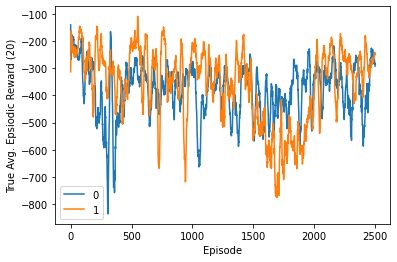

total time: 24370.818846940994 s


In [42]:
run(total_trials=2, total_episodes=2500, buffer_capacity=300000, tau=0.002, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=10000, continuous=True, critic_lr_func=decreasing_clr,
   actor_lr_func=decreasing_alr, std_dev_func=decreasing_std)

In [104]:
run(total_trials=1, total_episodes=30, buffer_capacity=500000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=40000, continuous=True)

ValueError: in user code:

    File "C:\Users\Ferdi\AppData\Local\Temp\ipykernel_14212\555187538.py", line 83, in update  *
        self.critic_optimizer.apply_gradients(
    File "C:\ProgramData\Miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 678, in apply_gradients  **
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "C:\ProgramData\Miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 723, in _distributed_apply
        update_op = distribution.extended.update(
    File "C:\ProgramData\Miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 706, in apply_grad_to_update_var  **
        update_op = self._resource_apply_dense(grad, var, **apply_kwargs)
    File "C:\ProgramData\Miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py", line 170, in _resource_apply_dense
        return tf.raw_ops.ResourceApplyAdam(

    ValueError: Tried to convert 'grad' to a tensor and failed. Error: Shapes must be equal rank, but are 2 and 1
    	From merging shape 10 with other shapes. for '{{node Adam/Adam/update/ResourceApplyAdam/packed}} = Pack[N=12, T=DT_FLOAT, axis=0](Adam/IdentityN, Adam/IdentityN:1, Adam/IdentityN:2, Adam/IdentityN:3, Adam/IdentityN:4, Adam/IdentityN:5, Adam/IdentityN:6, Adam/IdentityN:7, Adam/IdentityN:8, Adam/IdentityN:9, Adam/IdentityN:10, Adam/IdentityN:11)' with input shapes: [8,16], [16], [16,32], [32], [2,32], [32], [64,400], [400], [400,300], [300], [300,2], [2].


Ep 0 * AvgReward -273.42 * true AvgReward -273.42 * Reward -273.42 * True Reward -273.42 * time 10.70 * step 123
Ep 1 * AvgReward -416.16 * true AvgReward -416.16 * Reward -558.90 * True Reward -558.90 * time 6.13 * step 195
Ep 2 * AvgReward -425.73 * true AvgReward -425.73 * Reward -444.87 * True Reward -444.87 * time 5.81 * step 266
Ep 3 * AvgReward -392.04 * true AvgReward -392.04 * Reward -290.99 * True Reward -290.99 * time 4.33 * step 317
Ep 4 * AvgReward -491.27 * true AvgReward -491.27 * Reward -888.19 * True Reward -888.19 * time 6.43 * step 403


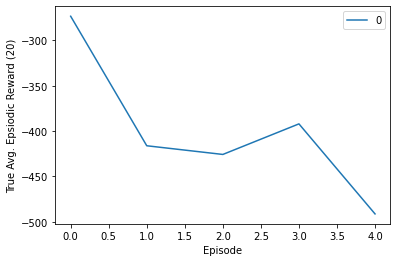

total time: 33.82937574386597 s


In [97]:
run(total_trials=1, total_episodes=5, buffer_capacity=500000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=100, continuous=False)